Hi everyone,

I copied over the data from stampede to wombat.  It's located in

/work/lqcd/d20a/users/agrebe/0vbb/stampede-data

The six folders (production-runs-?-no-sparsening) are the three original streams (A-C) and their continuations (D-F).

The 4pt data files are in the format
[op1 time] [op2 time] [sink time] [real] [imaginary]
where operator and sink times are relative to the source time.  The files have 2109 * 6 * ncfg lines, for 2109 combinations of source/op1/op2/sink separations, 6 different sink locations, and ncfg configurations, all cat'd together.  Thus, one should average each 6 consecutive blocks of 2109 lines.

The 2-point files are {di,}nucleon-2pt-WP and are in the format
[source time] [sink-source separation] [real] [imaginary]
These have 48 * 48 * ncfg lines, since there are 48 source locations and 48 source-sink separations for each source.  The 48 sources should be averaged on each config.

I can send around Python scripts to do the averaging if the formats are unclear.

Best,
Anthony

* NPLQCD: https://arxiv.org/pdf/2004.07404.pdf
* Luchang: https://arxiv.org/pdf/2208.03834.pdf (pi0 -> e+e-)
* Luchang:https://arxiv.org/pdf/2206.00879.pdf (0vbb)

* Overleaf for Long-distance NME 0vbb: https://www.overleaf.com/project/6256d880230a37ec75b699d3
* Overleaf for Short-distance NME 0vbb: https://www.overleaf.com/project/6256e711230a377505b821f1

/work/lqcd/d20a/users/agrebe/0vbb/stampede-data

## imports

In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import gvar as gv
import lsqfit
from importlib import reload
import seaborn as sns
from collections import namedtuple
import os
import re
from tqdm import tqdm
import itertools
import datetime
from functools import reduce

import data_io_nn as io
from lqcd_analysis import visualize as plt
from lqcd_analysis import correlator
from lqcd_analysis import analysis
from lqcd_analysis import statistics as stats

In [2]:
out_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/talk_figs'

# Stats defs

In [3]:
def count_ndata(ydata):
    """ Counts the number of data points in ydata."""
    ndata = 0
    if hasattr(ydata, 'keys'):
        for key in ydata.keys():
            ndata += len(np.asarray(ydata[key]).flatten())
    else:
        ndata = len(np.asarray(ydata).flatten())
    return ndata


def count_nparams(params):
    """
    Counts the number of fit parameters np, being careful
    to avoid double counting of "log priors" are present.
    """
    nparams = 0
    for pname, val in params.items():
        log_pname = 'log({0})'.format(pname)
        if log_pname in params.keys():
            # Skip this parameter
            continue
        if hasattr(val, '__len__'):
            nparams += len(np.asarray(val).flatten())
        else:
            nparams += 1
    return nparams


def aic(fit):
    """
    Computes the Akaike information criterion for a given fit.
    """
    return fit.chi2 + 2.0 * count_nparams(fit.p)


def aic_model_probability(fit):
    """
    Computes the model probability associated with the Akaike information
    criterion. Generically, the raw (unnormalized) model probability is
    raw prob = exp( -0.5 * IC).
    In the present case,
    IC = AIC - 2*(Ny - Ncut)
       = chi^2 + 2*Nparams - 2*(Ny - Ncut).
    This definition uses the following pieces:
    * chi^2 is the augmented chi2,
    * Nparams is the number of parameters in the model,
    * Ny is the total number data points, and
    * Ncut is the number of points cut / dropped by choosing tmin
    The difference (Ny - Ngamma) > 0 is simply "Ndata", the total number of
    data points included in the fit. For a fixed model and fixed raw dataset,
    Nparams and Ny are constant and cancel in the normalized probabilites used
    in model averaging. So, for fixed model and fixed raw dataset,
    IC --> chi^2 + 2 Ncut.
    """
    ndata = count_ndata(fit.y)
    ic = aic(fit) - 2.0 * ndata
    # Recall the basic log-likelihood function in least-squares fitting is
    # -1/2 * chi2^2, with a factor of -1/2. So we must multiply the information
    # criterion by -1/2 in order to get the full log-likelihood.
    log_likelihood = -0.5 * ic
    return np.exp(log_likelihood)

from inspect import getfullargspec

def compute_chi2(fit, augmented=False, trust_lsqfit=False):
    """Computes the chi2 function."""
    if trust_lsqfit:
        if not augmented:
            LOGGER.warning((
                "Caution: lsqfit computes an augmented chi2 function."
                "Trusting lsqfit as specified anyway."
            ))
        return fit.chi2
    # Standard chi2, without the term involving the prior
    argspec = getfullargspec(fit.fcn)
    if (argspec.args == ['x', 'p']) or (argspec.args == ['self', 'x', 'p']):
        result = correlated_chi2(fit.fcn(fit.x, fit.p), fit.y)
    else:
        result = correlated_chi2(fit.fcn(fit.p), fit.y)
    if augmented:
        # Augmeted chi2, including the term with the prior
        result += correlated_chi2(fit.p, fit.prior)
    return result

def correlated_chi2(yfit, ydata):
    """Computes the correlated chi2 function."""
    # Get the fit values, data, and covariance matrix as dicts
    cov_dict = gv.evalcov(ydata)
    # Enforce an ordering of keys
    klist = list(ydata.keys())
    # Reserve space for arrays
    # Implementation note: flatten allows for the special case
    # of matrix-valued priors, e.g., for the transition matrix Vnn
    sizes = [len(np.asarray(ydata[key]).flatten()) for key in klist]
    total_size = sum(sizes)
    diff = np.empty(total_size)
    cov_arr = np.zeros((total_size, total_size))
    # Infer the start and end points for intervals
    ends = np.cumsum(sizes)
    starts = ends - sizes
    # Populate arrays
    for start_i, end_i, key_i in zip(starts, ends, klist):
        diff[start_i:end_i] = np.asarray(gv.mean(ydata[key_i] - yfit[key_i])).flatten()
        for start_j, end_j, key_j in zip(starts, ends, klist):
            try:
                cov_arr[start_i:end_i, start_j:end_j] =\
                    cov_dict[(key_i, key_j)]
            except ValueError:
                # Implementation note: matrix-valued priors have
                # multi-dimensional covariance matrices,
                # which must be reshaped in a 2x2 array
                cov_arr[start_i:end_i, start_j:end_j] = \
                    cov_dict[(key_i, key_j)].reshape(
                        end_i - start_i, end_j - start_j
                    )
    # The "usual" chi2 function (ydata-yfit).cov_inv.(ydata-yfit)
    try:
        result = np.dot(diff, np.linalg.solve(cov_arr, diff))
    except np.linalg.LinAlgError:
        result = np.nan
    return result

# Quick pictures

In [4]:
reload(io)

# runs = ['A', 'B', 'C', 'D', 'E', 'F']
runs = ['C', 'D', 'E', 'F']
# root = "/Users/willjay/Research/BetaDecay/Data/NN/production-runs-{run}-no-sparsening/results/all/"
root = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw/run_{run}/'

tags = [
    "dinucleon-2pt-PP",
#     "dinucleon-2pt-PP-full",
    "dinucleon-2pt-WP",
#     "nnpp-3pt",
#     "nnpp-4pt",
    "nucleon-2pt-WP",
#     "sigma-3pt",
#     "sigma-4pt",
]
corrs = {}
data = {}
tcut = 24
for tag in tags:
    print(f"Reading {tag}")
    data_tmp = []  # accumulate data across runs
    for run in runs:
        fname = os.path.join(root.format(run=run), tag)
        try:
            raw = io.read_2pt(fname)
        except FileNotFoundError:
            print(f"--> Missing {tag} {run}")
            continue
        arr = io.avg_src_2pt(raw)
        arr = arr[:, :tcut]
        if tag == "nucleon-2pt-WP":
            arr = -1*arr
        print(f"--> {run} {arr.shape}")
        data_tmp.append(arr)
    data[tag] = np.vstack(data_tmp)
ds = gv.dataset.avg_data(data)
    
# Normalize
for key in ds:
    ds[key] = ds[key] / gv.mean(ds[key][0])
    
    
    # data = gv.dataset.avg_data(data)

# c2 = correlator.TwoPoint(tag, gv.dataset.avg_data(data))
# corrs[tag] = c2


Reading dinucleon-2pt-PP
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)
Reading dinucleon-2pt-WP
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)
Reading nucleon-2pt-WP
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)


dinucleon-2pt-PP
dinucleon-2pt-WP
nucleon-2pt-WP


(2.0, 3.0)

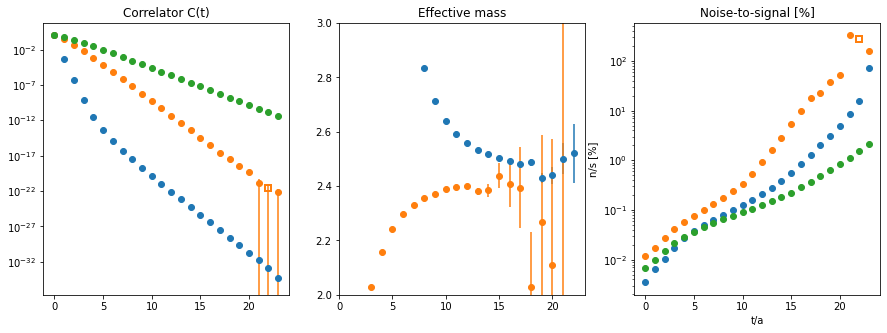

In [5]:
fig, axarr = plt.subplots(ncols=3, figsize=(15, 5))
for k, v in ds.items():
    print(k)
    c2 = correlator.TwoPoint(k, v)
    c2.plot_summary(axarr=axarr)
axarr[1].set_ylim(2, 3)

In [6]:
def model_pp(t, p):
    amp_wall = p['amp:w']
    amp_point = p['amp:p']
    dE = p['dE']
    result = 0
    for E, ai in zip(np.cumsum(dE), amp_point):
        result = result + (ai**2) * np.exp(-E*t)
    return result

def model_wp(t, p):
    amp_wall = p['amp:w']
    amp_point = p['amp:p']
    dE = p['dE']
    result = 0
    for E, ai, bi in zip(np.cumsum(dE), amp_wall, amp_point):
        result = result + (ai*bi) * np.exp(-E*t)
    return result


# Just does a multi-exponential fit... not sure what diag does
class Fitter:
    def __init__(self, y, diag=True):
        self.y = y
        self.diag = diag
        
    def get_prior(self, nstates):
        mpi_MeV = 800
        a_fm = 0.145
        hbarc = 197
        mpi = mpi_MeV * a_fm / hbarc
        if self.diag:
            dE = [gv.gvar(2.5, 0.1)] + [gv.gvar(mpi, mpi) for _ in range(nstates-1)]
        else:
            dE = [gv.gvar(2.5, 0.5)] + [gv.gvar(mpi, mpi) for _ in range(nstates-1)]
        amp = [gv.gvar(0, 5.)] + [gv.gvar(0.5, 5) for _ in range(nstates-1)]
        return {'dE': dE, 'amp': amp}

    def model(self, t, p):
        amp = p['amp']
        dE = p['dE']
        result = 0
        for E, ai in zip(np.cumsum(dE), amp):
            if self.diag:
                # Convexity of diagonal correlators
                result = result + ai*np.sign(ai) * np.exp(-E*t)
            else:
                result = result + ai * np.exp(-E*t)
        return result
    
    def __call__(self, nstates, tmin, tmax=None, **kwargs):
        prior = kwargs.pop('prior', self.get_prior(nstates))    
        if tmax is None:
            tmax = len(self.y)
        x = np.arange(tmin, tmax)
        y = self.y[tmin:tmax]
        return lsqfit.nonlinear_fit(data=(x, y), fcn=self.model, prior=prior, **kwargs)


# 2pt fits

## N Individual fits

In [7]:
#################
# Wall-to-point #
#################

key = 'nucleon-2pt-WP'
fitter = Fitter(y=ds[key], diag=False)
fits_N = []
for nstates in range(1, 6):
    for tmin in range(4, 12):
        fit = fitter(nstates=nstates, tmin=tmin)
        result = {
            'key': key,
            'nstates': nstates,
            'tmin': tmin,
            'chi2/dof': fit.chi2/fit.dof,
            'Q': fit.Q,
            'fit': fit,
        }
        for idx, E in enumerate(np.cumsum(fit.p['dE'])):
            result[f'E:{idx}'] = E
        for idx, amp in enumerate(fit.p['amp']):
            result[f'amp:{idx}'] = amp
        fits_N.append(result)

# fits_N is a pandas DataFrame of all the fits, indexed by results
fits_N = pd.DataFrame(fits_N)        

,nstates,tmin,E:0,chi2/dof,Q
7,1,11,1.20239(36),1.623908,0.070766
14,2,10,1.2044(10),1.328635,0.180767
16,3,4,1.1994(52),1.807563,0.014763
17,3,5,1.192(22),1.465016,0.086650
19,3,7,1.20421(58),1.466101,0.096430
22,3,10,1.2044(10),1.328889,0.180621
23,3,11,1.2039(12),1.338675,0.181539
24,4,4,1.193(20),1.535020,0.059272
25,4,5,1.191(26),1.400493,0.114086
28,4,8,1.20390(63),1.486172,0.094449


<AxesSubplot:>

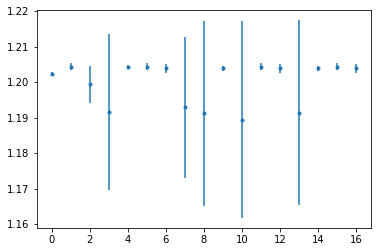

In [8]:
# Only look at fits with chi^2 / dof < 2 and noise-to-signal ratio < 0.1 (less than 10% noise)
mask =\
    (fits_N['chi2/dof'] <= 2) &\
    (fits_N['E:0'].apply(analysis.n2s) < 0.1)

display(fits_N[mask][['nstates','tmin','E:0','chi2/dof','Q']])

fig, ax = plt.subplots(1)

y = fits_N[mask]['E:0']


x = np.arange(len(y))
plt.errorbar(ax, x, y, fmt='.')


## NN Individual Fits

In [9]:
fits = []

##################
# Point-to-point #
##################

key = 'dinucleon-2pt-PP'
fitter = Fitter(y=ds[key], diag=True)
for nstates in range(1, 6):
    for tmin in range(4, 12):
        fit = fitter(nstates=nstates, tmin=tmin)
        result = {
            'key': key,
            'nstates': nstates,
            'tmin': tmin,
            'chi2/dof': fit.chi2/fit.dof,
            'Q': fit.Q,
            'fit': fit,
        }
        for idx, E in enumerate(np.cumsum(fit.p['dE'])):
            result[f'E:{idx}'] = E
        for idx, amp in enumerate(fit.p['amp']):
            result[f'amp:{idx}'] = amp
        fits.append(result)

#################
# Wall-to-point #
#################

key = 'dinucleon-2pt-WP'
fitter = Fitter(y=ds[key], diag=False)
for nstates in range(1, 6):
    for tmin in range(4, 12):
        fit = fitter(nstates=nstates, tmin=tmin)
        result = {
            'key': key,
            'nstates': nstates,
            'tmin': tmin,
            'chi2/dof': fit.chi2/fit.dof,
            'Q': fit.Q,
            'fit': fit,
        }
        for idx, E in enumerate(np.cumsum(fit.p['dE'])):
            result[f'E:{idx}'] = E
        for idx, amp in enumerate(fit.p['amp']):
            result[f'amp:{idx}'] = amp
        fits.append(result)
        
        
fits = pd.DataFrame(fits)        

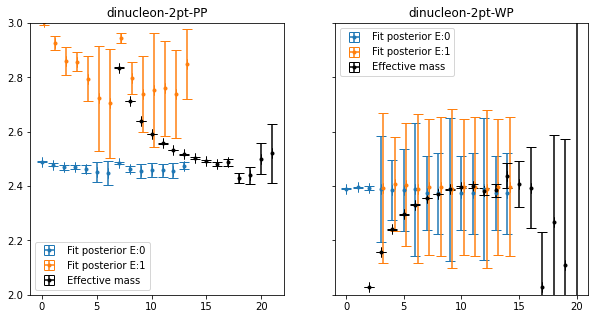

In [10]:
fig, axarr = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

mask = fits['chi2/dof'] <= 2

# subdf is all accepted fits (i.e. all fits with chi^2/dof < 2), grouped by the 2 tags of WP and PP. 
# this first loop basically just loops over the two keys, either WP (wall-point) or PP (point-point)
for ax, (key, subdf) in zip(axarr, fits[mask].groupby('key')):
    # this loop goes over excited states, idx = 0 is ground state, idx = 1 is 1st excited state. 
    for idx in range(0, 2):
        y = subdf[f'E:{idx}']
        x = np.arange(len(y)) + idx*0.2
        plt.errorbar(ax, x, y, fmt='.', capsize=5, label=f'Fit posterior E:{idx}')
    fit = subdf.head(1)['fit'].item()

    y = correlator.effective_mass(ds[key])
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, color='k', fmt='.', capsize=5, label='Effective mass')
    ax.set_ylim(2, 3)
    ax.legend()
    ax.set_title(key)

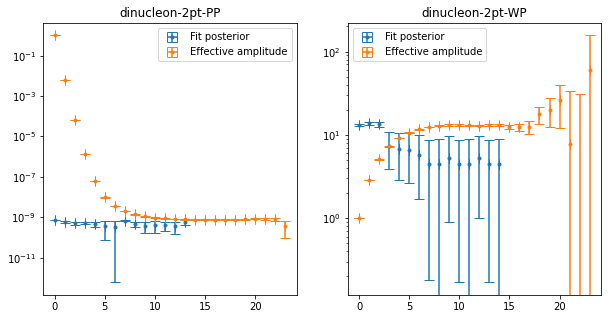

In [11]:
fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))

mask = (fits['chi2/dof'] <= 2)
for ax, (key, subdf) in zip(axarr, fits[mask].groupby('key')):
    
    # Plot fit posterior
    y = subdf['amp:0']
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5, label='Fit posterior')
    
    # Plot effective amplitude
    E = subdf.head(1)['E:0'].item()
    y = ds[key] 
    t = np.arange(len(y))
    y = np.exp(+E*t) * y
    plt.errorbar(ax, t, y, fmt='.', capsize=5, label='Effective amplitude')
    ax.set_yscale("log")
    ax.set_title(key)
    ax.legend()

## Joint PP+WP fits

In [12]:
class JointFitter:
    def __init__(self, pp, wp):
        if len(pp) != len(wp):
            raise ValueError("Incommensurate data?")
        self.pp = pp
        self.wp = wp
    
    def model(self, x, p):
        return {'PP': model_pp(x, p), 'WP': model_wp(x, p)}
    
    def get_prior(self, nstates):
        mpi_MeV = 800
        a_fm = 0.145
        hbarc = 197
        mpi = mpi_MeV * a_fm / hbarc
    
        dE = [gv.gvar(2.5, 0.5)] + [gv.gvar(mpi, mpi) for _ in range(nstates-1)]
        amp_point = [gv.gvar(1.0, 0.25)] + [gv.gvar(0.5, 5) for _ in range(nstates-1)]
        amp_wall = [gv.gvar(0.5, 5) for _ in range(nstates)]
        return {'dE': dE, 'amp:p': amp_point, 'amp:w': amp_wall}
        
    def __call__(self, nstates, tmin, tmax=None, **kwargs):
        if 'prior' in kwargs:
            prior = kwargs.pop('prior')
        else:
            raise NotImplementedError("Please specify a prior")
        y = {'PP': self.pp[tmin:tmax], 'WP': self.wp[tmin:tmax]}
        if tmax is None:
            tmax = len(self.pp)
        x = np.arange(tmin, tmax)
        return lsqfit.nonlinear_fit(data=(x, y), fcn=self.model, prior=prior, **kwargs)
    

In [13]:
State = namedtuple('State', ['E','amp'])
NStates = namedtuple('Nstates', ['pp', 'wp'])

def build_prior(nstates, pp, wp):
    
    def bundle(mean, frac):
        return gv.gvar(mean, frac*mean)
    
    # Hard-coded ensemble-specific data
    mpi_MeV = 800
    a_fm = 0.145
    hbarc = 197
    mpi = mpi_MeV * a_fm / hbarc

    E0 = np.mean(gv.mean(pp.E) + gv.mean(wp.E))/2
    E0 = bundle(E0, 0.1)
    
    amp_p = np.sqrt(gv.mean(pp.amp))
    amp_w = gv.mean(wp.amp / amp_p)

    amp_p = bundle(amp_p, 2.5)
    amp_w = bundle(amp_w, 10)
        
    dE = [E0] + [gv.gvar(mpi, mpi) for _ in range(max(nstates)-1)]
    amp_point = [amp_p] + [gv.gvar(0.5, 5) for _ in range(nstates.pp-1)]
    amp_wall = [amp_w] +  [bundle(amp_w.mean, 5) for _ in range(nstates.wp-1)]    
    return {
        'log(dE)': np.log(dE),
        'log(amp:p)': np.log(amp_point),
        'amp:w': amp_wall}


# Isolate best fits
mask_pp = (fits['key'] == 'dinucleon-2pt-PP') & (fits['chi2/dof'] <= 2.0)
mask_wp = (fits['key'] == 'dinucleon-2pt-WP') & (fits['chi2/dof'] <= 2.0)

best_pp = (fits.index == fits[mask_pp]['chi2/dof'].idxmin())
pp = State(E=fits[best_pp]['E:0'].item(), amp=fits[best_pp]['amp:0'].item())

best_wp = (fits.index == fits[mask_wp]['chi2/dof'].idxmin())
wp = State(E=fits[best_wp]['E:0'].item(), amp=fits[best_wp]['amp:0'].item())

In [14]:
fitter = JointFitter(
    pp=ds['dinucleon-2pt-PP'], 
    wp=ds['dinucleon-2pt-WP'])

fits_joint = []

for tmin in range(3, 15):
    nstates = NStates(3, 2)
    prior = build_prior(nstates, pp, wp)
    fit = fitter(nstates=nstates, tmin=tmin, prior=prior)

    result = {
        'key': key,
        'nstates': nstates,
        'tmin': tmin,
        'chi2/dof': fit.chi2/fit.dof,
        'Q': fit.Q,
        'fit': fit,
    }
    for idx, E in enumerate(np.cumsum(fit.p['dE'])):
        result[f'E:{idx}'] = E
    for idx, amp in enumerate(fit.p['amp:w']):
        result[f'amp:w:{idx}'] = amp
    for idx, amp in enumerate(fit.p['amp:p']):
        result[f'amp:p:{idx}'] = amp
    fits_joint.append(result)
fits_joint = pd.DataFrame(fits_joint)
    

/var/folders/q2/tk_jvj_106gddw96ph0kg7r40000gn/T/ipykernel_55228/1136050169.py:3: RuntimeWarning: overflow encountered in exp
  amp_point = p['amp:p']


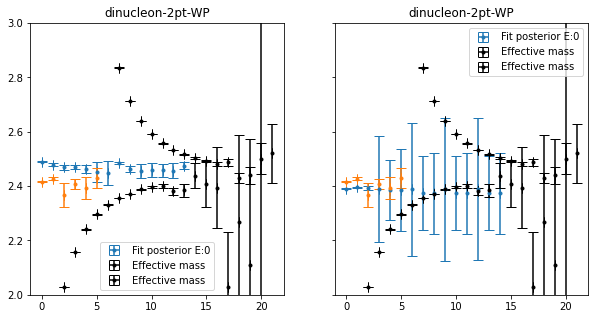

In [15]:
fig, axarr = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

mask = fits['chi2/dof'] <= 2

for ax, (key, subdf) in zip(axarr, fits[mask].groupby('key')):

    # Single-fit results
    for idx in [0]:
        y = subdf[f'E:{idx}']
        x = np.arange(len(y)) + idx*0.2
        plt.errorbar(ax, x, y, fmt='.', capsize=5, label=f'Fit posterior E:{idx}')
    fit = subdf.head(1)['fit'].item()

    # Joint-fit results
    mask = (fits_joint['chi2/dof'] <= 2.0)
    y = fits_joint[mask]['E:0']
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)

    # Effective masses
    for key in fits['key'].unique():
        y = correlator.effective_mass(ds[key])
        x = np.arange(len(y))
        plt.errorbar(ax, x, y, color='k', fmt='.', capsize=5, label='Effective mass')
    
    ax.set_ylim(2, 3)
    ax.legend()
    ax.set_title(key)

               key  nstates  tmin  chi2/dof        Q  \
19  nucleon-2pt-WP        3     7  1.466101  0.09643   

                                                  fit          E:0      amp:0  \
19  Least Square Fit:\n  chi2/dof [dof] = 1.5 [17]...  1.20421(58)  4.266(33)   

          E:1      amp:1       E:2     amp:2  E:3 amp:3  E:4 amp:4  
19  1.683(33)  -5.63(92)  2.28(58)  0.6(5.0)  NaN   NaN  NaN   NaN  


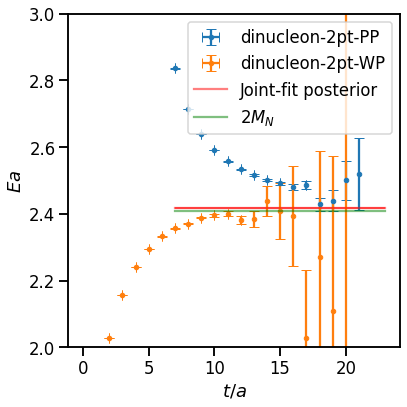

In [16]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(6, 6))
    for key in fits['key'].unique():
        y = correlator.effective_mass(ds[key])
        x = np.arange(len(y))
        plt.errorbar(ax, x, y, fmt='.', capsize=5, label=key)

    mask = fits_joint['tmin'] == 7
    E = fits_joint[mask]['E:0'].item()
    x = np.arange(7, 24)
    y = np.ones(len(x))*E
    plt.errorbar(ax=ax, x=x, y=y, color='r', bands=True, alpha=0.5, label='Joint-fit posterior')

    mask = (fits_N['tmin'] == 7) & (fits_N['nstates'] == 3)
    E = fits_N[mask]['E:0'].item()
    print(fits_N[mask])
    x = np.arange(7, 24)
    y = np.ones(len(x))*E*2
    plt.errorbar(ax=ax, x=x, y=y, color='g', bands=True, alpha=0.5, label=r'$2 M_N$')

    ax.set_ylim(2, 3)
    ax.legend(loc='upper right')
    ax.set_xlabel(r"$t/a$")
    ax.set_ylabel(r"$Ea$")
    fig.tight_layout()
    #fig.savefig("Figures/dinucleon_fit.pdf")

# 4pt data

In [17]:
reload(io)

runs = ['A', 'B', 'C', 'D', 'E', 'F']

# root = "/Users/willjay/Research/BetaDecay/Data/NN/production-runs-{run}-no-sparsening/results/all/"
root = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw/run_{run}/'

tag = "dinucleon-2pt-WP"
tcut = 24

# Read in 2-point data (WP)
print(f"Reading {tag}")
data_tmp = []  # accumulate data across runs
for run in runs:
    fname = os.path.join(root.format(run=run), tag)
    try:
        raw = io.read_2pt(fname)
    except FileNotFoundError:
        print(f"--> Missing {tag} {run}")
        continue
    arr = io.avg_src_2pt(raw)
    arr = arr[:, :tcut]
    if tag == "nucleon-2pt-WP":
        arr = -1*arr
    print(f"--> {run} {arr.shape}")
    data_tmp.append(arr)
data_tmp = np.vstack(data_tmp)
c2 = gv.dataset.avg_data(data_tmp)
    

Reading dinucleon-2pt-WP
--> A (618, 24)
--> B (1029, 24)
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)


In [18]:
reload(io)
runs = ['A', 'B', 'C', 'D', 'E', 'F']
# root = "/Users/willjay/Research/BetaDecay/Data/NN/production-runs-{run}-no-sparsening/results/all/"
root = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw/run_{run}/'
# Read in 4-point data
for run in runs:
    print("Reading data for run", run)
    datadir = root.format(run=run)
    fname = os.path.join(datadir, "nnpp-4pt")
    df = io.read_4pt(fname)
    data = io.avg_4pt(df)

Reading data for run A
Reading data for run B
Reading data for run C
Reading data for run D
Reading data for run E
Reading data for run F


In [19]:
# Now shift so that the second operator is defined to be at the origin

data['t-'] = data['tsrc'] - data['top2']
data['t+'] = data['tsnk'] - data['top2']
data['v'] = data['top1'] - data['top2']
data['dt'] = data['t+'] - data['t-']
data['dt+'] = data['t+'] - data['v'].apply(lambda val: max(val, 0))
data['dt-'] = data['v'].apply(lambda val: min(val, 0)) - data['t-']
data['|v|'] = data['v'].apply(np.abs)

In [20]:
data

,tsrc,top1,top2,tsnk,corr,t-,t+,v,dt,dt+,dt-,|v|
0,0,3,3,6,-0.003205(10),-3,3,0,6,3,3,0
1,0,3,3,7,-0.00023674(99),-3,4,0,7,4,3,0
2,0,3,3,8,-0.000018594(99),-3,5,0,8,5,3,0
3,0,3,3,9,-1.500(11)e-06,-3,6,0,9,6,3,0
4,0,3,3,10,-1.246(14)e-07,-3,7,0,10,7,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2104,0,20,16,23,-2.7(2.5)e-20,-16,7,4,23,3,16,4
2105,0,20,17,23,-4.4(3.7)e-20,-17,6,3,23,3,17,3
2106,0,20,18,23,-3.6(5.6)e-20,-18,5,2,23,3,18,2
2107,0,20,19,23,-2.2(9.4)e-20,-19,4,1,23,3,19,1


In [21]:
def get_normalization(c, dt):
    return 1/c[dt]

data['norm'] = data[['dt']].apply(lambda tple: get_normalization(c2, *tple), axis=1)
data['ratio'] = data['corr'] * data['norm']
# data['ratio'] here is the C4 / C2 ratio

In [22]:
data

,tsrc,top1,top2,tsnk,corr,t-,t+,v,dt,dt+,dt-,|v|,norm,ratio
0,0,3,3,6,-0.003205(10),-3,3,0,6,3,3,0,3.2366(31),-0.010375(35)
1,0,3,3,7,-0.00023674(99),-3,4,0,7,4,3,0,33.342(41),-0.007894(34)
2,0,3,3,8,-0.000018594(99),-3,5,0,8,5,3,0,351.90(57),-0.006543(36)
3,0,3,3,9,-1.500(11)e-06,-3,6,0,9,6,3,0,3768.8(8.3),-0.005652(44)
4,0,3,3,10,-1.246(14)e-07,-3,7,0,10,7,3,0,41038(130),-0.005113(60)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,0,20,16,23,-2.7(2.5)e-20,-16,7,4,23,3,16,4,9(42)e+17,-0.02(12)
2105,0,20,17,23,-4.4(3.7)e-20,-17,6,3,23,3,17,3,9(42)e+17,-0.04(19)
2106,0,20,18,23,-3.6(5.6)e-20,-18,5,2,23,3,18,2,9(42)e+17,-0.03(16)
2107,0,20,19,23,-2.2(9.4)e-20,-19,4,1,23,3,19,1,9(42)e+17,-0.02(12)


3


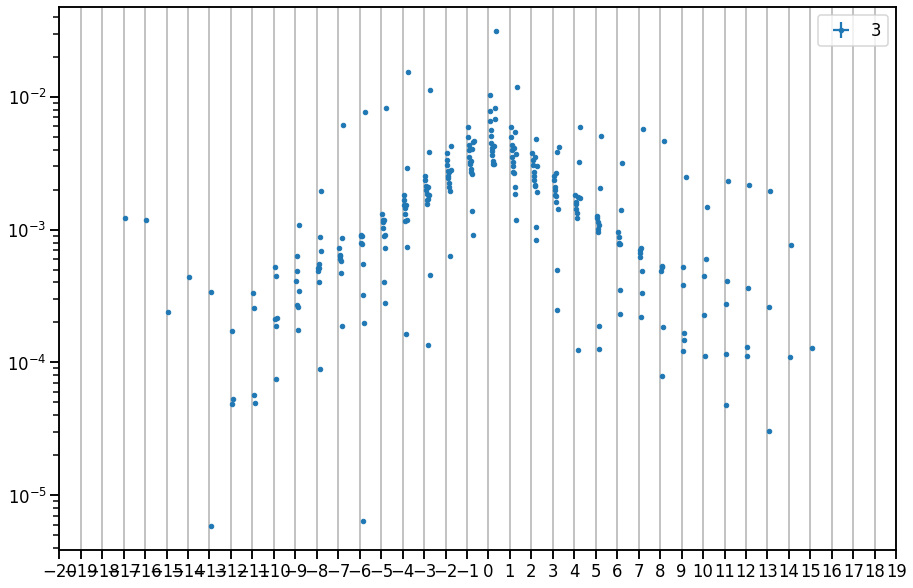

In [23]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    for dtplus, subdf in data.groupby('dt-'):
        if dtplus != 3:
            break    
        print(dtplus)
        y = -subdf['ratio'].values
        x = subdf['v'] + subdf['dt+']/60
        plt.errorbar(ax=ax, x=x, y=gv.mean(y), fmt='.', label=dtplus)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xticks(np.arange(-20,20))
    ax.grid(axis='x')

In [24]:
data.groupby('|v|').size()

|v|
0     171
1     306
2     272
3     240
4     210
5     182
6     156
7     132
8     110
9      90
10     72
11     56
12     42
13     30
14     20
15     12
16      6
17      2
dtype: int64

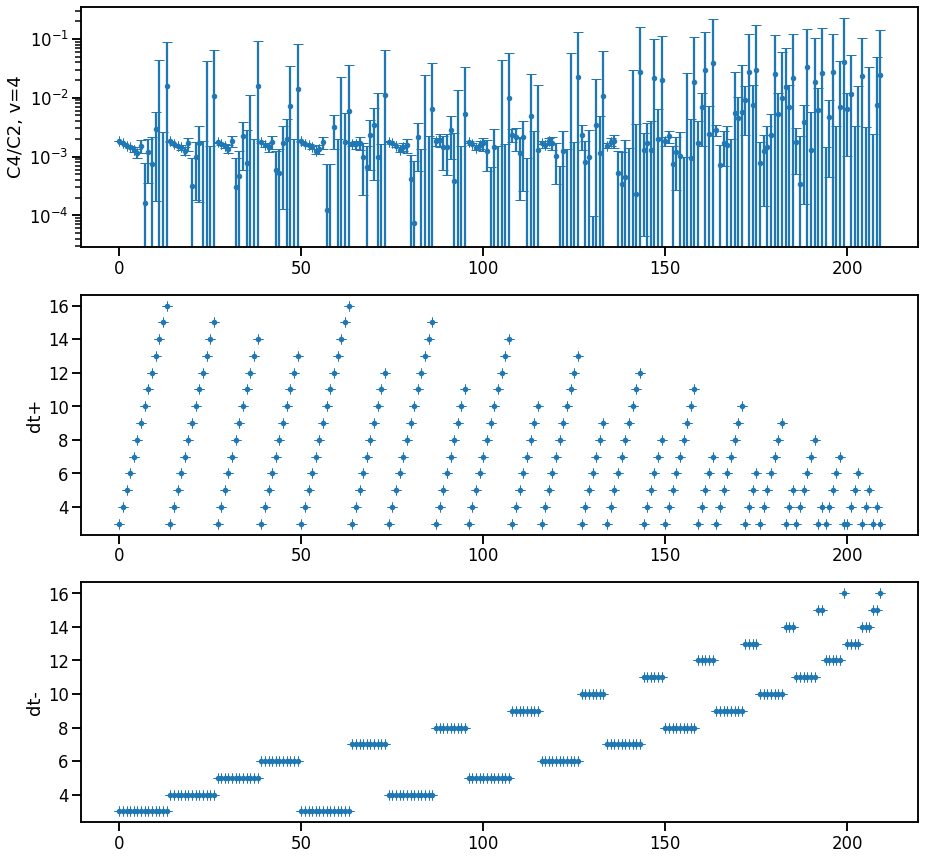

In [25]:
with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(nrows=3, figsize=(15, 15))
    ax1, ax2, ax3 = axarr
    for v, subdf in data.groupby('|v|'):
        if len(subdf) != 210:
            continue
        y = -subdf['ratio'].values
        x = np.arange(len(y))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax1, x=x+offset, y=y, fmt='.', capsize=5)
        plt.errorbar(ax=ax2, x=x, y=subdf['dt+'], fmt='.', capsize=5)
        plt.errorbar(ax=ax3, x=x, y=subdf['dt-'], fmt='.', capsize=5)
        ax1.set_ylabel("C4/C2, v="+str(v))
        
    ax2.set_ylabel("dt+")
    ax3.set_ylabel("dt-")
    
    ax1.set_yscale("log")

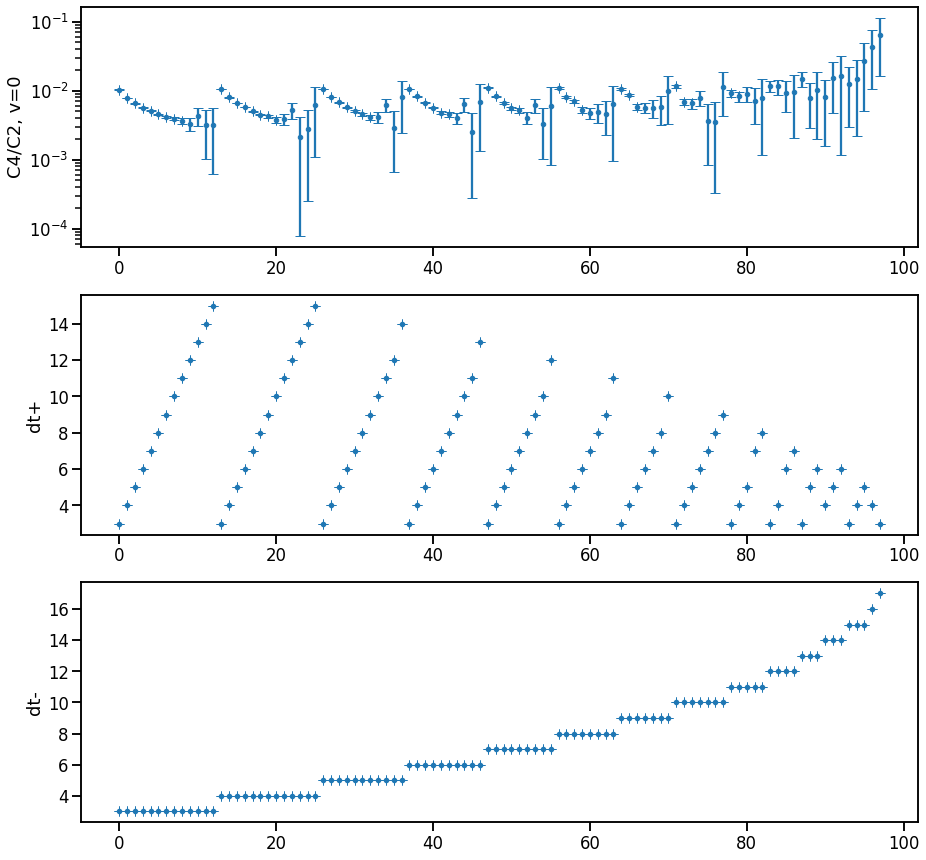

In [26]:
with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 1
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        if v != 0:
            continue
        subdf = subdf.sort_values(by=['dt-','dt+'])
            
        y = -subdf['ratio'].values
        x = np.arange(len(y))
        offset = 0 if v > 0 else 0.5
        fig, axarr = plt.subplots(nrows=3, figsize=(15, 15))
        ax1, ax2, ax3 = axarr
        plt.errorbar(ax=ax1, x=x, y=y, fmt='.', capsize=5, color=color)
        plt.errorbar(ax=ax2, x=x, y=subdf['dt+'], fmt='.', capsize=5, color=color)
        plt.errorbar(ax=ax3, x=x, y=subdf['dt-'], fmt='.', capsize=5, color=color)

        ax1.set_ylabel("C4/C2, v="+str(v))
        ax2.set_ylabel("dt+")
        ax3.set_ylabel("dt-")
        ax1.set_yscale("log")

        
        break

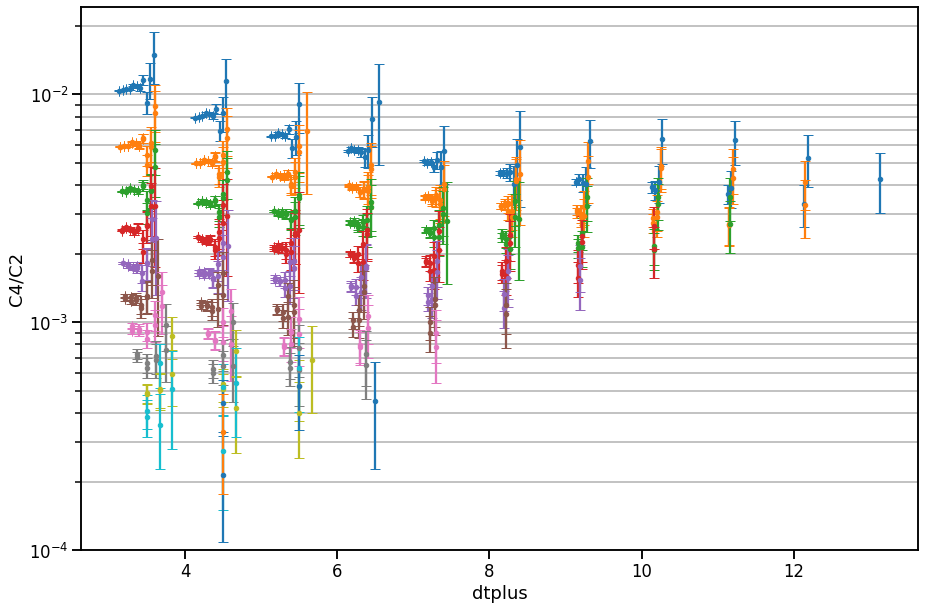

In [27]:
with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 0.5
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, ax = plt.subplots(nrows=1, figsize=(15, 10))
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        subdf = subdf.sort_values(by=['dt-','dt+'])
            
        y = -subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(2*len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5

        plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
    ax.set_ylabel("C4/C2")
    ax.set_xlabel("dtplus")
    ax.set_yscale("log")
    ax.grid(axis='y', which='both')
    ax.set_ylim(bottom=1e-4)

## Fit to ratio

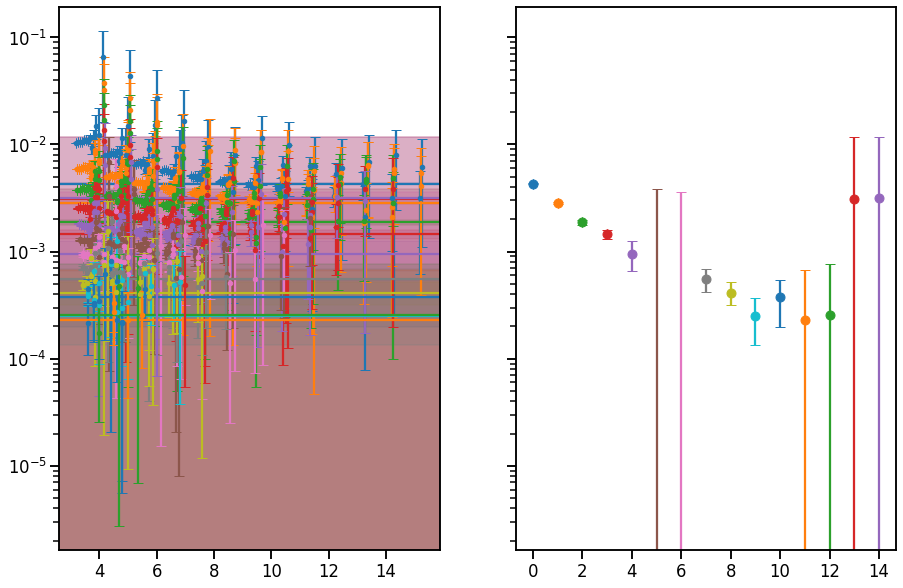

In [28]:
def ratio_model(x, p):
    """
    C4/C2 = R(v) + A(v)*exp[-(tplus - v)*\Delta E]
    """
    dtplus = x
    return p['plateau'] + p['amp'] * np.exp(-dtplus * p['dE'])

def constant_model(x, p):
    return p['plateau']


fits_ratio = []

with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 1.0
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, axarr = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)

    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):

        if v <= np.inf:
            fcn = ratio_model
            prior = {
                'plateau': gv.gvar(1e-2, 1e-2),
                'amp': gv.gvar(0.05, 0.05),
                'dE': gv.gvar(0.5, 0.5),
            }
        else:
            fcn = constant_model
            prior = {
                'plateau': gv.gvar(1e-2, 1e-2),
            }
        subdf = subdf.sort_values(by=['dt-','dt+'])

        y = -subdf['ratio'].values
        x = subdf['dt+'].values


        fit = lsqfit.nonlinear_fit(data=(x,y), fcn=fcn, prior=prior)
        fits_ratio.append({
            'v': v,
            'fit': fit,
            'chi2/dof': fit.chi2/fit.dof,
            'p': fit.p,
            'plateau': fit.p['plateau'],
            'dE': fit.p.get('dE', np.nan),
            'amp': fit.p.get('amp', np.nan),
        })
            
            
            
        y = -subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        ax = axarr[0]
        plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
        plt.axhline(ax=ax, y=fit.p['plateau'], color=color)

        ax = axarr[1]
        plt.errorbar(ax=ax, x=v, y=fit.p['plateau'], capsize=5, fmt='o', color=color)
        
        
    axarr[0].set_yscale("log")

fits_ratio = pd.DataFrame(fits_ratio)




Least Square Fit (no prior):
  chi2/dof [dof] = 0.9 [12]    Q = 0.54    

Parameters:
              A   0.0201 (24)     [   1 +- inf ]  
              B     2.46 (17)     [   1 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 12/0.1)
  fitter = scipy_least_squares    method = trf

Least Square Fit (no prior):
  chi2/dof [dof] = 0.84 [12]    Q = 0.61    

Parameters:
            amp   0.00395 (12)      [ 0.005 +- inf ]  
          delta     0.325 (26)      [     1 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 11/0.0)
  fitter = scipy_least_squares    method = trf



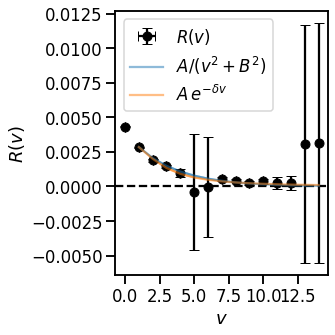

In [29]:
def model_cauchy(x, p):
    return p['A'] / (x**2 + p['B']**2)

def model_exp(x, p):
    return p['amp'] * np.exp(-x*p['delta'])





y = fits_ratio['plateau'].values
x = fits_ratio['v'].values

vcut = 1


p0 = {'A': 1.0, 'B': 1.0}
fit_cauchy = lsqfit.nonlinear_fit(data=(x[vcut:], y[vcut:]), fcn=model_cauchy, p0=p0)
print(fit_cauchy)


p0 = {'amp': 0.005, 'delta': 1.0}
fit_exp = lsqfit.nonlinear_fit(data=(x[vcut:], y[vcut:]), fcn=model_exp, p0=p0)
print(fit_exp)

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, figsize=(5, 5))
    plt.errorbar(ax, x, y, fmt='o', color='k', capsize=5, label=r'$R(v)$')


    vcut = 1
    plt.errorbar(ax, x[vcut:], fit_exp.fcn(x[vcut:], fit_exp.p),
                 bands=True, alpha=0.5,
                 label=r'$A/(v^2+B^2)$'
                )

    plt.errorbar(ax, x[vcut:], fit_cauchy.fcn(x[vcut:], fit_cauchy.p),
                 bands=True, alpha=0.5,
                 label=r'$A\,e^{-\delta v}$'
                )

    ax.legend()
    ax.set_xlabel(r"$v$")
    ax.set_ylabel(r"$R(v)$")
    ax.axhline(y=0, color='k', ls='--')
    fig.tight_layout()
    #fig.savefig("Figures/asymptotic_ratio.pdf")

In [30]:
def ratio_model(x, p):
    """
    C4/C2 = R(v) + A(v)*exp[-(tplus - v)*\Delta E]
    """
    dtplus = x
    return p['plateau'] + p['amp'] * np.exp(-dtplus * p['dE'])

def constant_model(x, p):
    return p['plateau']*np.ones(len(x))

def run_ratio_fit(data):
    prior = {
        'plateau': gv.gvar(1e-2, 1e-2),
        'amp': gv.gvar(0.05, 0.05),
        'dE': gv.gvar(0.5, 0.5),
    }
    return lsqfit.nonlinear_fit(data=data, fcn=ratio_model, prior=prior)

def run_constant_fit(data):
    prior = {'plateau': gv.gvar(1e-2, 1e-2)}
    return lsqfit.nonlinear_fit(data=data, fcn=constant_model, prior=prior)



fits_ratio = []

for noise_cut in [1.0]:
    for dtplus_cut in range(3, 6):
        mask =\
            (data['ratio'].apply(analysis.n2s).apply(np.abs) < noise_cut) &\
            (data['dt+'] > dtplus_cut)
        
        for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):

            y = -subdf['ratio'].values
            x = subdf['dt+'].values

            fit = run_constant_fit(data=(x,y))
            fits_ratio.append({
                'model': 'const',
                'v': v,
                'fit': fit,
                'chi2/dof': fit.chi2/fit.dof,
                'p': fit.p,
                'plateau': fit.p['plateau'],
                'dE': fit.p.get('dE', np.nan),
                'amp': fit.p.get('amp', np.nan),
                'weight': aic_model_probability(fit),
            })
            fit = run_ratio_fit(data=(x,y))
            fits_ratio.append({
                'model': 'exp',
                'v': v,
                'fit': fit,
                'chi2/dof': fit.chi2/fit.dof,
                'p': fit.p,
                'plateau': fit.p['plateau'],
                'dE': fit.p.get('dE', np.nan),
                'amp': fit.p.get('amp', np.nan),
                'weight': aic_model_probability(fit),
            })

fits_ratio = pd.DataFrame(fits_ratio)





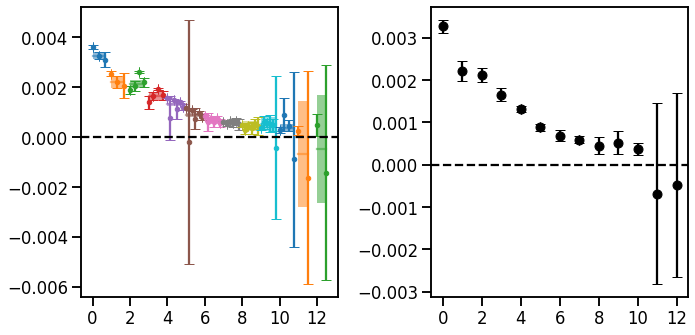

In [31]:
with sns.plotting_context('talk'):
    fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))

    mask = (fits_ratio['chi2/dof'] < 2)
    for v, subdf in fits_ratio[mask].groupby('v'):

        y = subdf['plateau'].values
        x = v + np.arange(len(y)) / len(y)

        weight = (subdf['weight'] / subdf['weight'].sum()).values
#         yavg = stats.model_avg(y, weight)
        yavg = np.median(y)
        stat = gv.sdev(yavg)
#         syst = (max(gv.mean(y)) - min(gv.mean(y)))        
        syst = 0
        yavg = gv.gvar(gv.mean(yavg), np.sqrt(stat**2 + syst**2))
                    
    
        
        ax = axarr[0]    
        plt.errorbar(ax, x, y, fmt='.', capsize=5)
        plt.errorbar(ax=ax, x=[min(x), max(x)], y=[yavg, yavg], bands=True, 
                     color=ax.lines[-1].get_color(), alpha=0.5)
        ax = axarr[1]
        plt.errorbar(ax=ax, x=v, y=yavg, color='k', fmt='o', capsize=5)




    for ax in axarr:
        ax.axhline(y=0, color='k', ls='--')
    fig.tight_layout()



# Correlated ratio

## Read data

In [32]:
# reload(io)

# runs = ['A', 'B', 'C', 'D', 'E', 'F']

# root = "/Users/willjay/Research/BetaDecay/Data/NN/production-runs-{run}-no-sparsening/results/all/"

# tcut = 24

# data_tmp = []  # accumulate data across runs

# def parse_line(line):
#     tokens = line.split()
#     return int(tokens[0]), int(tokens[1]), int(tokens[2]), float(tokens[3]), float(tokens[4])


# tmp = []

# for run in ['A', 'B', 'C', 'D', 'E', 'F']:
#     print("Reading", run)
#     fname = os.path.join(root.format(run=run), "nnpp-4pt")
    
#     tmp.append(io.read_4pt(fname))
# data = pd.concat(tmp)

In [33]:
reload(io)

runs = ['A', 'B', 'C', 'D', 'E', 'F']

# root = "/Users/willjay/Research/BetaDecay/Data/NN/production-runs-{run}-no-sparsening/results/all/"
root = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw/run_{run}/'


tcut = 24

tmp2 = []
tmp4 = []

data_tmp = []  # accumulate data across runs
for run in ['A', 'B', 'C', 'D', 'E', 'F']:
    print(f"Reading {run}")
    # Accumulate 2pt data
    fname = os.path.join(root.format(run=run), "dinucleon-2pt-WP")
    tmp2.append(io.get_2pt(fname, tcut=tcut, sign=-1))
    tmp2[-1]['series'] = run
    # Accumulate 4pt data
    fname = os.path.join(root.format(run=run), "nnpp-4pt")
    tmp4.append(io.read_4pt(fname))
    tmp4[-1]['series'] = run
    
df2 = pd.concat(tmp2)
df4 = pd.concat(tmp4)
data = io.correlate_ratio(df2, df4, ntimes=tcut)
    

Reading A
Reading B
Reading C
Reading D
Reading E
Reading F


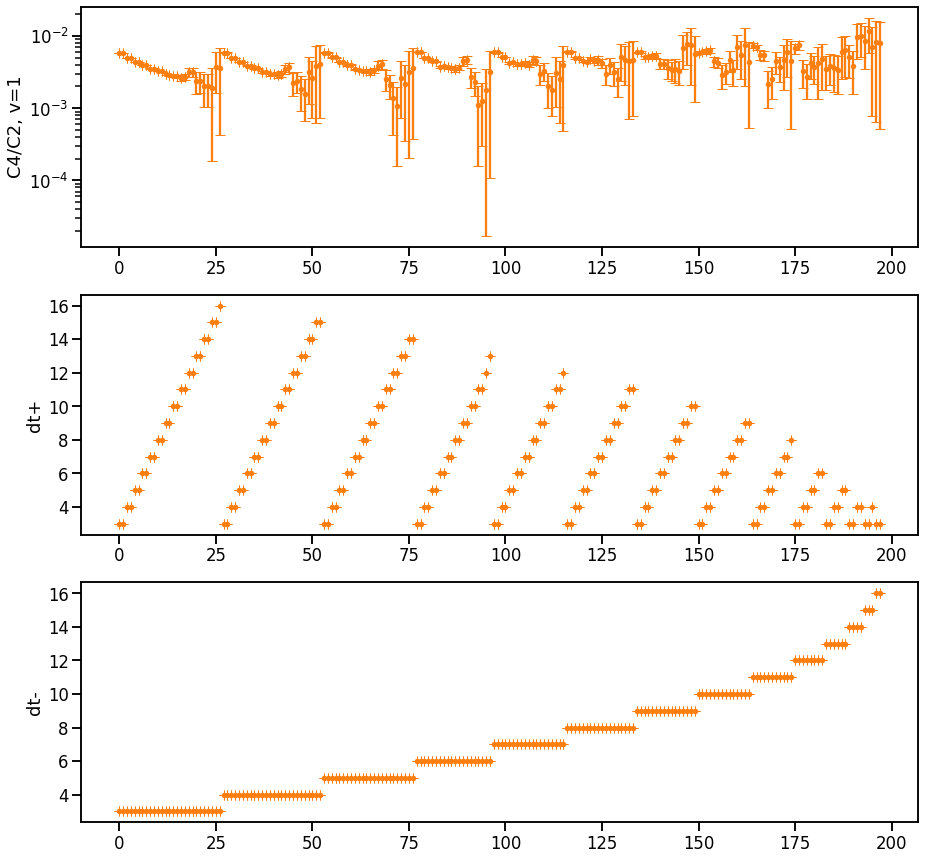

In [34]:

with sns.plotting_context("talk"):
#     mask = data['ratio'].apply(analysis.n2s) < np.inf
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 1
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        if v != 1:
            continue
        subdf = subdf.sort_values(by=['dt-','dt+'])
            
        y = subdf['ratio'].values
        x = np.arange(len(y))
        offset = 0 if v > 0 else 0.5
        fig, axarr = plt.subplots(nrows=3, figsize=(15, 15))
        ax1, ax2, ax3 = axarr
        plt.errorbar(ax=ax1, x=x, y=y, fmt='.', capsize=5, color=color)
        plt.errorbar(ax=ax2, x=x, y=subdf['dt+'], fmt='.', capsize=5, color=color)
        plt.errorbar(ax=ax3, x=x, y=subdf['dt-'], fmt='.', capsize=5, color=color)

        ax1.set_ylabel("C4/C2, v="+str(v))
        ax2.set_ylabel("dt+")
        ax3.set_ylabel("dt-")
        ax1.set_yscale("log")

        
        break

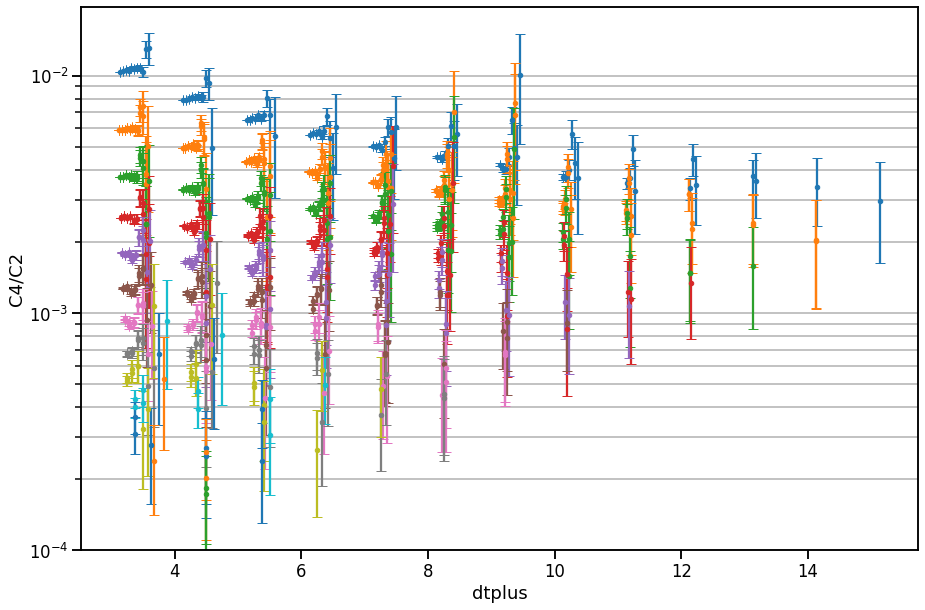

In [35]:
with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 0.5
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, ax = plt.subplots(nrows=1, figsize=(15, 10))
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        subdf = subdf.sort_values(by=['dt-','dt+'])
            
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(2*len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5

        plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
    ax.set_ylabel("C4/C2")
    ax.set_xlabel("dtplus")
    ax.set_yscale("log")
    ax.grid(axis='y', which='both')
    ax.set_ylim(bottom=1e-4)

## Run fits

### Local

Least Square Fit:
  chi2/dof [dof] = 1.2 [62]    Q = 0.1    logGBF = 425.51

Parameters:
   log(plateau)     -5.740 (25)      [ -5.8 (3.3) ]  
        log(a+)     -4.100 (27)      [ -3.0 (1.0) ]  *
       log(dE+)     -1.135 (31)      [ -1.4 (2.0) ]  
        log(a-)      -3.0 (1.0)      [ -3.0 (1.0) ]  
       log(dE-)      -1.4 (2.0)      [ -1.4 (2.0) ]  
---------------------------------------------------
        plateau   0.003214 (80)      [ 0.003 (10) ]  
             a+    0.01657 (45)      [ 0.050 (50) ]  
            dE+      0.321 (10)      [  0.25 (50) ]  
             a-      0.050 (50)      [ 0.050 (50) ]  
            dE-       0.25 (50)      [  0.25 (50) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 8/0.0)
  fitter = scipy_least_squares    method = trf

Least Square Fit:
  chi2/dof [dof] = 1 [104]    Q = 0.49    logGBF = 778.66

Parameters:
   log(plateau)    -6.085 (52)      [ -5.8 (3.3) ]  
        log(a+)    -4.914 (34)      [ -3.0 

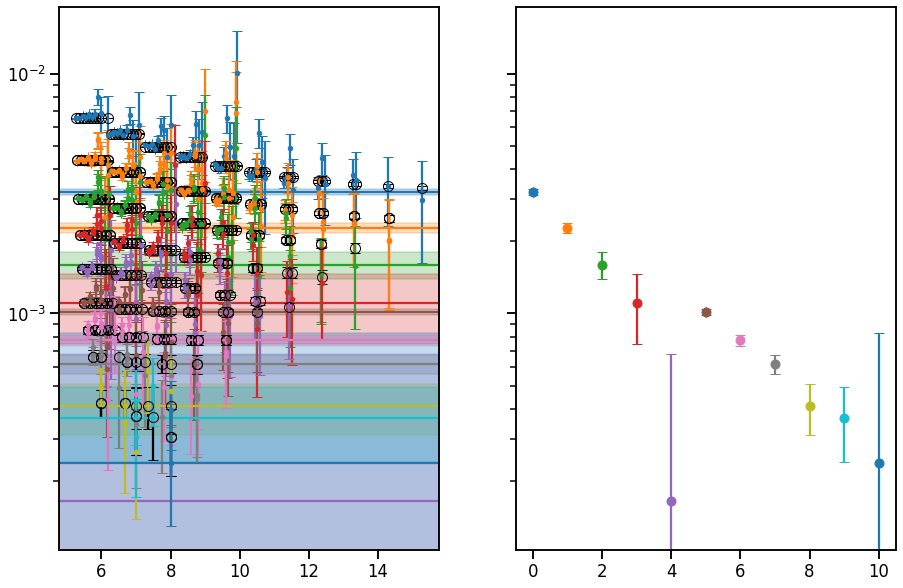

In [36]:
def ratio_model(x, p):
    """
    C4/C2 = R(v) + A(v)*exp[-(tplus - v)*\Delta E]
    """
    dtp = x['dt+']
    tm = x['t-']
    return p['plateau'] + p['a+'] * np.exp(-dtp * p['dE+']) #+ p['a-']*np.exp(-np.abs(tm)*p['dE-'])

def constant_model(x, p):
    return p['plateau']


fits_ratio = []

with sns.plotting_context("talk"):
    mask =\
        (data['ratio'].apply(analysis.n2s).apply(np.abs) < 0.5) &\
        (data['dt+'] > 4) 
    
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, axarr = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)

    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
#         if v != 0:
#             continue
        subdf = subdf.sort_values(by=['dt+','dt-'])
        if v <= np.inf:
            fcn = ratio_model
            x = {
                'dt+': subdf['dt+'].values,
                't-': subdf['t-'].values,
            }
            prior = {
                'log(plateau)': np.log(gv.gvar(3e-3, 1e-2)),
                'log(a+)': np.log(gv.gvar(0.05, 0.05)),
                'log(dE+)': np.log(gv.gvar(0.25, 0.5)),
                'log(a-)': np.log(gv.gvar(0.05, 0.05)),
                'log(dE-)': np.log(gv.gvar(0.25, 0.5)),
            }
        else:
            fcn = constant_model
            x = {'dt+': subdf['dt+'].values}
            prior = {
                'plateau': gv.gvar(1e-2, 1e-2),
            }
        y = subdf['ratio'].values
        fit = lsqfit.nonlinear_fit(data=(x,y), fcn=fcn, prior=prior)
        fits_ratio.append({
            'v': v,
            'fit': fit,
            'chi2/dof': fit.chi2/fit.dof,
            'p': fit.p,
            'plateau': fit.p['plateau'],
            'dE': fit.p.get('dE', np.nan),
            'amp': fit.p.get('amp', np.nan),
            'ap': fit.p.get('a+', np.nan),
            'am': fit.p.get('a-', np.nan),
            'dE-': fit.p.get('dE-', np.nan),
            'dE+': fit.p.get('dE+', np.nan),
        })
        print(fit.format())

        ax = axarr[0]
        # Plot fit results
        yfit = fit.fcn(x, fit.p)
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        plt.errorbar(ax=ax, x=x, y=yfit, fmt='o', ms=10, capsize=5, color='k', markerfacecolor='none')
            
        # Plot data
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
        plt.axhline(ax=ax, y=fit.p['plateau'], color=color)

        ax = axarr[1]
        plt.errorbar(ax=ax, x=v, y=fit.p['plateau'], capsize=5, fmt='o', color=color)
        
    axarr[0].set_yscale("log")

fits_ratio = pd.DataFrame(fits_ratio)





<AxesSubplot:>

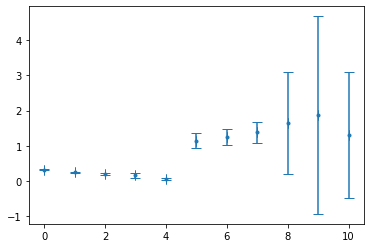

In [37]:
y = fits_ratio['dE+'].values
x = np.arange(len(y))
fig, ax = plt.subplots(1)
plt.errorbar(ax, x, y, fmt='.', capsize=5)


### Global

In [38]:
def model_single_time(x, p):
    triplets = [(x.tm, p.am, p.Em), (x.t0, p.a0, p.E0), (x.tp, p.ap, p.Ep)]
    result = 0
    for (time, amp, energy) in triplets:
        result = result + amp*np.exp(-energy*np.abs(time))
    return result


def global_model(x, p):
    result = []
    for (tm, t0, tp) in x:
        t0 = np.abs(t0)
        times = Times(tm, t0, tp)
        params = Params(
            p[f'log(am:{t0})'], # Different amplitude for each op1->op2 separation
            p['log(a0)'],
            p[f'log(ap:{t0})'],  # Different amplitude for each op1->op2 separation
            p['log(Em)'],
            p['log(E0)'],
            p['log(Ep)']
        )
        result.append(model_single_time(x=times, p=params))
    return np.array(result)


In [39]:

pbase = {}
pbase['log(a0)'] = np.log(gv.gvar(1.0, 1.0))
for t0 in data['v'].apply(np.abs).unique():
    pbase[f'log(am:{t0})'] = np.log(gv.gvar(1.0, 1.0))
    pbase[f'log(ap:{t0})'] = np.log(gv.gvar(1.0, 1.0))

pbase['log(Em)'] = np.log(gv.gvar(1.0, 1.0))
pbase['log(E0)'] = np.log(gv.gvar(1.0, 1.0))
pbase['log(Ep)'] = np.log(gv.gvar(1.0, 1.0))


Times = namedtuple('Times', ['tm', 't0', 'tp'])
Amplitudes = namedtuple('Amplitudes', ['am', 'a0', 'ap'])
Energies = namedtuple('Eneriges', ['Em', 'E0', 'Ep'])
Params = namedtuple('Params', ['am', 'a0', 'ap', 'Em', 'E0', 'Ep'])

mask = (data['dt+'] >= 3)


x = data[mask][['t-','v','dt+']].values
y = data[mask]['ratio'].values

# test evaluation of model function
global_model(x, pbase)

fit = lsqfit.nonlinear_fit(data=(x, y), fcn=global_model, prior=pbase)


print(fit)



Least Square Fit:
  chi2/dof [dof] = 4.3 [2109]    Q = 0    logGBF = 11841

Parameters:
        log(a0)     0.005201 (15)       [  0.0 (1.0) ]  
      log(am:0)    -0.000458 (21)       [  0.0 (1.0) ]  
      log(ap:0)      0.03735 (16)       [  0.0 (1.0) ]  
      log(am:1)    -0.000148 (12)       [  0.0 (1.0) ]  
      log(ap:1)     0.013807 (50)       [  0.0 (1.0) ]  
      log(am:2)   -0.0000792 (89)       [  0.0 (1.0) ]  
      log(ap:2)     0.005370 (22)       [  0.0 (1.0) ]  
      log(am:3)   -0.0000555 (73)       [  0.0 (1.0) ]  
      log(ap:3)     0.002276 (17)       [  0.0 (1.0) ]  
      log(am:4)   -0.0000398 (69)       [  0.0 (1.0) ]  
      log(ap:4)     0.001093 (16)       [  0.0 (1.0) ]  
      log(am:5)   -0.0000184 (73)       [  0.0 (1.0) ]  
      log(ap:5)     0.000610 (16)       [  0.0 (1.0) ]  
      log(am:6)     -4.4(8.8)e-06       [  0.0 (1.0) ]  
      log(ap:6)     0.000389 (18)       [  0.0 (1.0) ]  
      log(am:7)        -3(12)e-06       [  0.0 (1.0) ]  


In [40]:
x = data[['t-','v','dt+']].values
yfit = global_model(x, fit.p)
tmp = pd.DataFrame(data[['dt-','t-','v','|v|','dt+']])
tmp['ratio'] = yfit

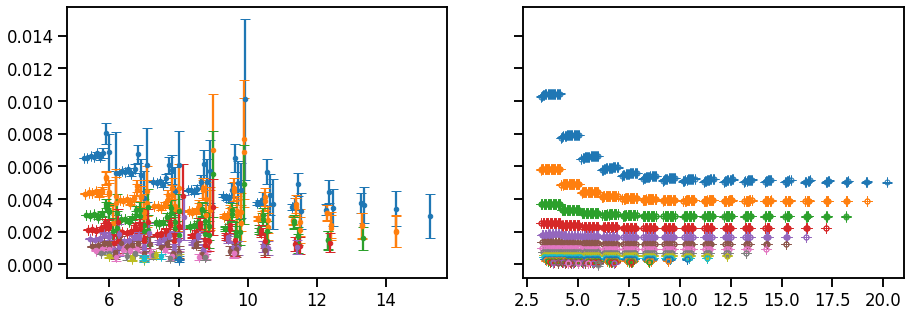

In [41]:


with sns.plotting_context("talk"):
    mask =\
        (data['ratio'].apply(analysis.n2s).apply(np.abs) < 0.5) &\
        (data['dt+'] > 4) 
    
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, axarr = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
    ax = axarr[0]
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):            
        # Plot data
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)

    ax = axarr[1]
    for (v, subdf), color in zip(tmp.groupby('|v|'), colors):            
        # Plot data
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax, x=x, y=y, fmt='o', ms=5, capsize=5, markerfacecolor='none', color=color)


# TODO LATER: probably just run what's below here

# Updated data - 2023-06-20

## Read data

In [42]:
reload(io)

# Read and process data
# base = "/Users/willjay/Research/BetaDecay/Data/NN/Update_20230616/"
# base = "/Users/wijay/Dropbox/Research/BetaDecay/Data/NN/Update_20230616/"
base = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/processed/'
fname2 = os.path.join(base, "nnpp-2pt")
fname4 = os.path.join(base, "nnpp-4pt")
c2 = np.loadtxt(fname2)
# df2 = pd.DataFrame(c2[:, :24]).reset_index(names='config')
df2 = pd.DataFrame(c2[:, :24]).reset_index().rename(columns={'index':'config'})
df4 = io.read_4pt(fname4, nblock=1)
data = io.correlate_ratio(df2, df4)

In [43]:
df2

,config,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,0,44832.613106,11781.163512,1940.491877,255.406007,28.642796,2.964649,0.299186,0.029533,0.002652,...,-1.843840e-09,-4.899544e-10,-1.273607e-10,1.253241e-11,4.207375e-12,8.951719e-13,9.172336e-14,-1.258488e-14,-2.786242e-15,-6.146033e-16
1,1,46671.553380,12284.373060,2014.394276,266.746019,29.860361,3.227149,0.316791,0.033030,0.002997,...,1.298955e-08,1.099198e-09,4.845565e-11,2.404419e-11,1.805460e-12,8.172126e-13,9.240276e-14,8.686682e-15,1.399005e-17,2.797197e-16
2,2,44330.889444,11665.392394,1905.905399,252.680743,29.165946,3.052921,0.313568,0.029257,0.002886,...,1.920145e-09,7.231909e-10,1.621173e-10,1.331069e-11,-4.677816e-12,-5.089268e-13,-8.703966e-14,-2.043179e-14,-2.254998e-15,2.375687e-16
3,3,45169.731009,11713.786130,1911.226136,254.373178,30.166626,3.627254,0.365160,0.033569,0.003169,...,-2.982824e-09,-2.544633e-10,-9.468474e-11,-1.905180e-11,1.998748e-12,7.361723e-13,1.265506e-13,7.280819e-15,-5.841620e-17,-5.316971e-16
4,4,44745.080123,11611.782701,1904.696645,255.168934,29.318685,3.138656,0.306376,0.028924,0.003063,...,8.288176e-09,3.025276e-10,-7.869784e-11,-4.321987e-11,-1.859280e-12,3.398088e-13,2.479274e-14,-9.427632e-14,-8.572857e-15,2.881875e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12131,12131,44706.651218,11691.228045,1880.197588,239.133403,27.795307,2.962615,0.304398,0.029075,0.002490,...,-1.758739e-09,-8.858889e-10,-2.393192e-10,-1.532859e-11,-2.579676e-12,-3.100951e-13,-1.767595e-14,-9.525849e-15,-1.809944e-15,-2.347535e-16
12132,12132,44177.935667,11581.647909,1882.119700,243.881999,27.296726,2.766288,0.272707,0.026208,0.002340,...,-7.267347e-09,-7.825628e-10,-7.329910e-11,3.235260e-12,1.974726e-12,6.543062e-13,4.482865e-14,-1.813637e-14,-2.573940e-15,-1.181361e-16
12133,12133,44571.527344,11475.284933,1857.511549,242.022699,27.632854,2.900996,0.297094,0.029249,0.002734,...,-3.678642e-09,-9.204634e-10,4.188572e-11,1.045306e-11,-3.007227e-13,8.023413e-13,1.132049e-13,2.576336e-14,-2.371924e-16,-2.170698e-16
12134,12134,44733.407577,11616.976110,1845.288547,239.049892,27.837966,3.050241,0.290729,0.027329,0.002430,...,6.267960e-10,-6.327622e-10,-1.359369e-10,-2.967485e-12,1.117492e-12,-2.242391e-13,5.591712e-14,1.737994e-14,-4.912532e-16,-3.007253e-16


In [44]:
data

,tsrc,top1,top2,tsnk,re,t-,t+,v,dt,dt+,dt-,|v|,ratio
0,0,3,3,6,0.0031990(50),-3,3,0,6,3,3,0,0.010354(14)
1,0,3,3,7,0.00023656(48),-3,4,0,7,4,3,0,0.007888(14)
2,0,3,3,8,0.000018505(49),-3,5,0,8,5,3,0,0.006512(16)
3,0,3,3,9,1.4908(56)e-06,-3,6,0,9,6,3,0,0.005619(20)
4,0,3,3,10,1.2297(70)e-07,-3,7,0,10,7,3,0,0.005047(28)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0,13,9,16,2.86(33)e-14,-9,7,4,16,3,9,4,0.00224(31)
502,0,13,10,16,3.71(48)e-14,-10,6,3,16,3,10,3,0.00290(43)
503,0,13,11,16,5.61(74)e-14,-11,5,2,16,3,11,2,0.00439(66)
504,0,13,12,16,9.6(1.2)e-14,-12,4,1,16,3,12,1,0.0075(11)


## Make figures

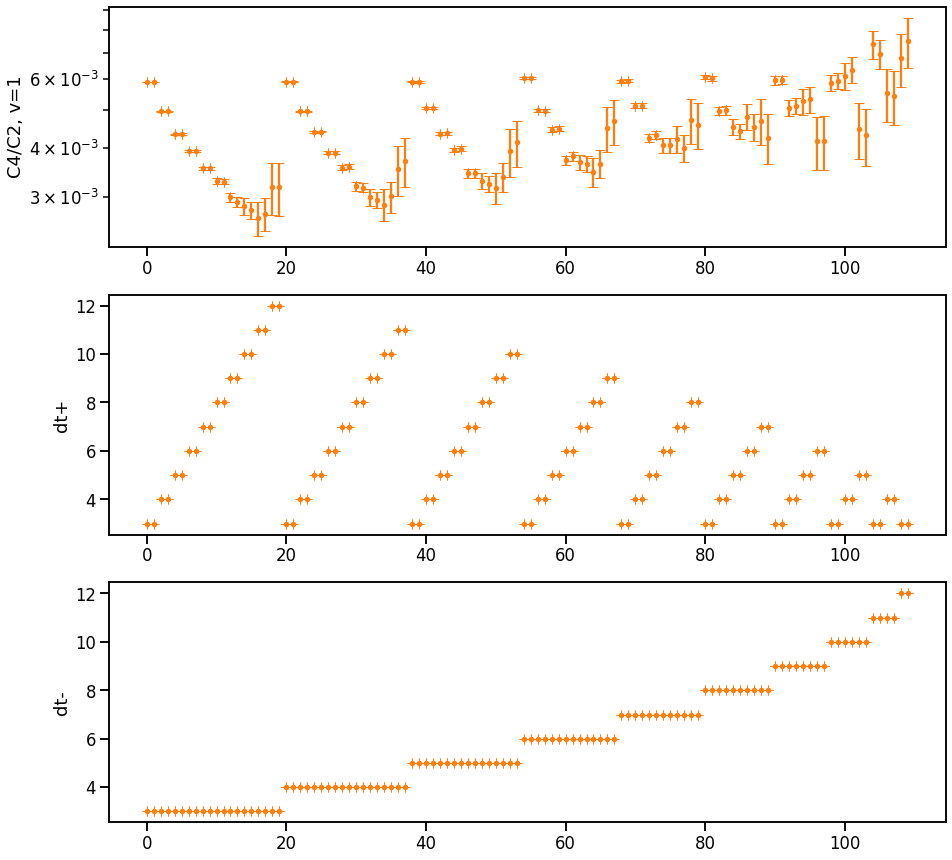

In [45]:
# recall v = operator separation, top1 - top2
with sns.plotting_context("talk"):
#     mask = data['ratio'].apply(analysis.n2s) < np.inf
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 1
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        if v != 1:
            continue
        subdf = subdf.sort_values(by=['dt-','dt+'])
            
        y = subdf['ratio'].values
        x = np.arange(len(y))
        offset = 0 if v > 0 else 0.5
        fig, axarr = plt.subplots(nrows=3, figsize=(15, 15))
        ax1, ax2, ax3 = axarr
        plt.errorbar(ax=ax1, x=x, y=y, fmt='.', capsize=5, color=color)
        plt.errorbar(ax=ax2, x=x, y=subdf['dt+'], fmt='.', capsize=5, color=color)
        plt.errorbar(ax=ax3, x=x, y=subdf['dt-'], fmt='.', capsize=5, color=color)

        ax1.set_ylabel("C4/C2, v="+str(v))
        ax2.set_ylabel("dt+")
        ax3.set_ylabel("dt-")
        ax1.set_yscale("log")

        
        break

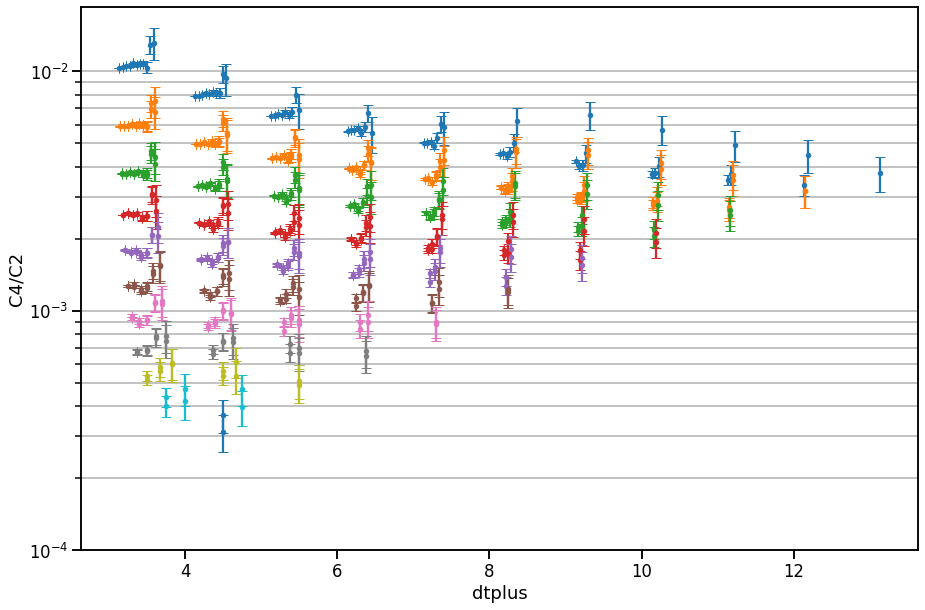

In [46]:
with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 0.5
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, ax = plt.subplots(nrows=1, figsize=(15, 10))
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        subdf = subdf.sort_values(by=['dt-','dt+'])
            
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(2*len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5

        plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
    ax.set_ylabel("C4/C2")
    ax.set_xlabel("dtplus")
    ax.set_yscale("log")
    ax.grid(axis='y', which='both')
    ax.set_ylim(bottom=1e-4)

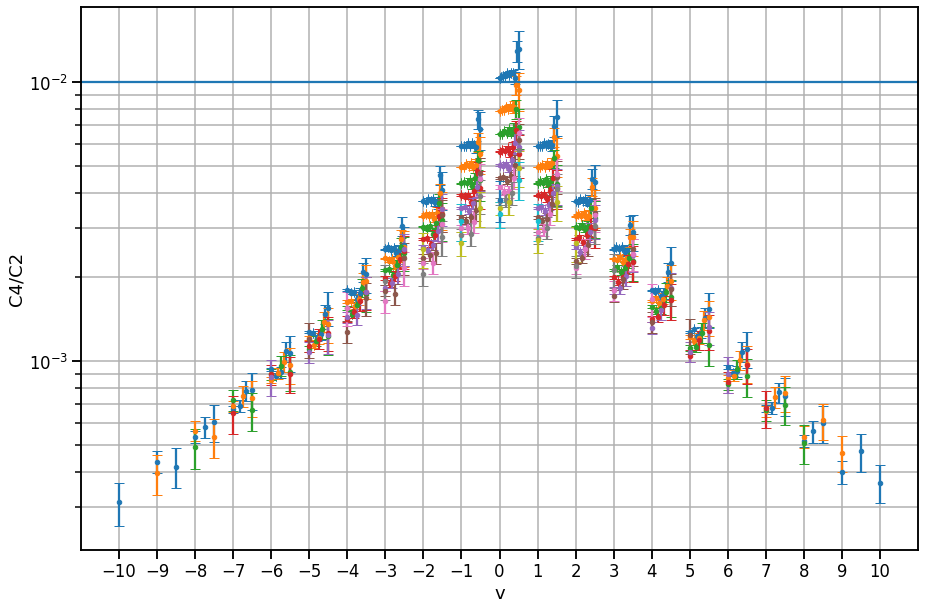

In [47]:
with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, ax = plt.subplots(nrows=1, figsize=(15, 10))
    for (dtp, subdf), color in zip(data[mask].groupby('dt+'), colors):
        subdf = subdf.sort_values(by=['v', 'dt-'])
            
        for v, ssubdf in subdf.groupby('v'):
            y = ssubdf['ratio'].values
            x = ssubdf['v'] + np.linspace(0, 0.5, num=len(ssubdf))
            plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
    ax.set_ylabel("C4/C2")
    ax.set_xlabel("v")
    ax.set_yscale("log")
    ax.set_xticks(np.arange(data['v'].min(), data['v'].max()+1))
    ax.grid(axis='y', which='both')
    ax.grid(axis='x')
    ax.axhline(y=0.01)
#     ax.set_ylim(bottom=1e-4)


## Run fits

### Local

In [48]:
def ratio_model(x, p):
    """
    C4/C2 = R(v) + A(v)*exp[-(tplus - v)*\Delta E]
    """
    dtp = x['dt+']
    tm = x['t-']
    return {'y': p['plateau'] + p['a+'] * np.exp(-dtp * p['dE+'])} #+ p['a-']*np.exp(-np.abs(tm)*p['dE-'])

def constant_model(x, p):
    return {'y': p['plateau']}

In [49]:
fits_ratio = []

for dtp_cut in [1,2,3,4,5,6]:

    mask =\
        (data['ratio'].apply(analysis.n2s).apply(np.abs) < 1.5) &\
        (data['dt+'] >= dtp_cut)
    
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):

        subdf = subdf.sort_values(by=['dt+','dt-'])
        if v <= 5:
            fcn = ratio_model
            x = {
                'dt+': subdf['dt+'].values,
                't-': subdf['t-'].values,
            }
            plateau_guess = gv.gvar(0.0035, 0.001)*np.exp(-gv.gvar(0.23, 0.05)*v)
            prior = {
                'log(plateau)': np.log(plateau_guess),
                'log(a+)': np.log(gv.gvar(0.05, 0.05)),
                'log(dE+)': np.log(gv.gvar(0.25, 0.5)),
#                 'log(a-)': np.log(gv.gvar(0.05, 0.05)),
#                 'log(dE-)': np.log(gv.gvar(0.25, 0.5)),
            }
            mode = 'ratio'
        else:
            fcn = constant_model
            x = {'dt+': subdf['dt+'].values}
            prior = {
                'plateau': gv.gvar(1e-2, 1e-2),
            }
            mode = 'constant'
        y = {'y': subdf['ratio'].values}
        fit = lsqfit.nonlinear_fit(data=(x,y), fcn=fcn, prior=prior)
        weight = aic_model_probability(fit)
        fits_ratio.append({
            'v': v,
            'fit': fit,
            'chi2': fit.chi2, 
            'chi2_aug': compute_chi2(fit, augmented=True),
            'chi2_data': compute_chi2(fit, augmented=False),
            'chi2/dof': fit.chi2/fit.dof,
            'dof': fit.dof,
            'nparam': len(fit.p),
            'Q': fit.Q,
            'weight': weight,
            'aic': -2*np.log(weight),
            'p': fit.p,
            'plateau': fit.p['plateau'],
            'a+': fit.p.get('a+', np.nan),
            'dE+': fit.p.get('dE+', np.nan),
            'dtp_cut': dtp_cut,
            'mode': mode,
        })
        
fits_ratio = pd.DataFrame(fits_ratio)


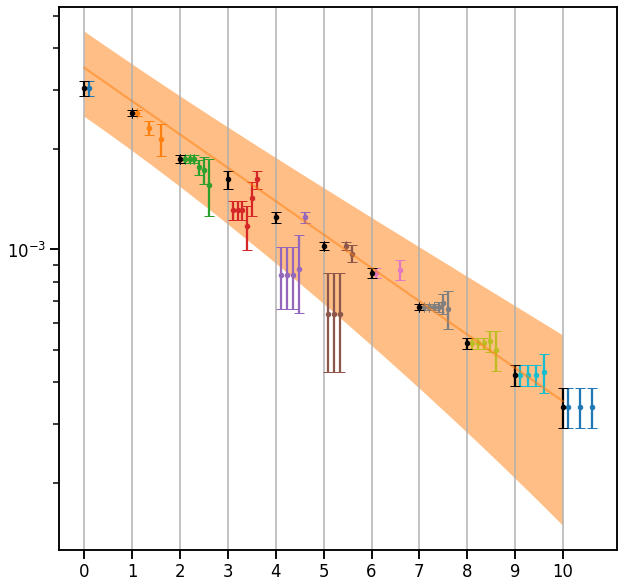

In [50]:
single_best = []

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    mask = (fits_ratio['chi2/dof'] < 1.5)
    for v, subdf in fits_ratio[mask].groupby('v'):
        x = v+ np.linspace(0, 0.5, num=len(subdf))
        x = x + 0.1
        y = subdf['plateau'].values
        plt.errorbar(ax, x, y, fmt='.', capsize=5)
#         if v == 2:
# #             best = (subdf.index == subdf['weight'].idxmax())
#             best = (subdf.index == subdf['plateau'].apply(analysis.n2s).idxmax())
#         else:
        best = (subdf.index == subdf['plateau'].apply(analysis.n2s).idxmin())
        y = subdf[best]['plateau'].values
        plt.errorbar(ax, [v], y, fmt='.', capsize=5, color='k')

        single_best.append({
            'plateau': y.item(),
            'v':v
        })
        


    ax.set_yscale("log")
    ax.set_xticks(range(11))
    ax.grid(True, axis='x')

    x = np.linspace(0, 10)

    y = gv.gvar(0.0035, 0.001)*np.exp(-gv.gvar(0.23, 0.05)*x)
    plt.errorbar(ax, x, y, bands=True, alpha=0.5)
    # ax.set_ylim(1e-8)
    
single_best = pd.DataFrame(single_best)

Least Square Fit:
  chi2/dof [dof] = 3.2 [11]    Q = 0.00027    logGBF = 70.624

Parameters:
        log(a0)     -5.752 (23)      [     -7 (1000) ]  
        log(E0)     -1.490 (18)      [    -1.2 (1.0) ]  
------------------------------------------------------
             a0   0.003178 (72)      [ 0.001 (1.000) ]  
             E0     0.2253 (41)      [     0.30 (30) ]  

Fit:
      key           y[key]         f(p)[key]
--------------------------------------------
      y 0     0.00304 (15)     0.003178 (72)  
        1    0.002560 (53)     0.002537 (50)  
        2    0.001866 (47)     0.002025 (35)  ***
        3     0.00162 (10)     0.001616 (26)  
        4    0.001251 (47)     0.001290 (20)  
        5    0.001024 (30)     0.001030 (16)  
        6    0.000852 (31)     0.000822 (14)  
        7    0.000673 (14)     0.000656 (13)  *
        8    0.000524 (20)     0.000524 (12)  
        9    0.000421 (31)     0.000418 (11)  
       10    0.000337 (46)    0.0003338 (96)  

Settin

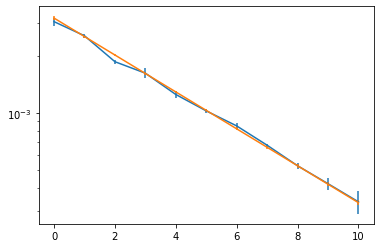

In [51]:
def model_reduced(x, p):
    return {'y': p['a0'] * np.exp(-x*p['E0'])}

prior = {
    'log(a0)': np.log(gv.gvar(1e-3, 1.0)),
    'log(E0)': np.log(gv.gvar(0.3, 0.3)),  
}

x = single_best['v'].values
y = {'y': single_best['plateau'].values}

fit = lsqfit.nonlinear_fit(data=(x,y), fcn=model_reduced, prior=prior)
print(fit.format(maxline=True))

yfit = fit.fcn(x, fit.p)

fig, ax = plt.subplots(1)
plt.errorbar(ax, x=x, y=y['y'])
plt.errorbar(ax, x=x, y=yfit['y'])
ax.set_yscale("log")

fit_reduced = pd.DataFrame({
    'v': x,
    'ratio': yfit['y'],
})

fit_alternative = fit


### Global

My analysis considers three models for the Euclidean time dependence
* "Basic" $C_4/C_2 = R(v) + A(v) e^{-(t_+ - v)E_+}$
* "Full" $C_4/C_2 = R(v) + A(v) e^{-(t_+ - v)E_+} + B(v) e^{-|t_-|E_-}$
* "Extra" $C_4/C_2 = R(v) + A(v) e^{-(t_+ - v)E_+} + B(v) e^{-(t_+ - t_-)E_-}$

In [52]:
def model_single_time(x, p, full):

    if full:
        # Include full time dependence
        triplets = [(x.tm, p.am, p.Em), (x.t0, p.a0, p.E0), (x.tp, p.ap, p.Ep)]
    else:
        # Neglect (small) time dependence on "t-"
        triplets = [(x.t0, p.a0, p.E0), (x.tp, p.ap, p.Ep)]    
    result = 0
    for (time, amp, energy) in triplets:
        result = result + amp*np.exp(-energy*np.abs(time))
    return result

def global_model_full(x, p):
    result = []
    for (tm, t0, tp) in x:
        t0 = np.abs(t0)
        times = Times(tm, t0, tp)
        params = Params(
            p[f'am:{t0}'], # Different amplitude for each op1->op2 separation
            p['a0'],
            p[f'ap:{t0}'],  # Different amplitude for each op1->op2 separation
            p['Em'],
            p['E0'],
            p['Ep']
        )
        result.append(model_single_time(x=times, p=params, full=True))
    return {'ratio' : np.array(result)}

def global_model(x, p):
    result = []
    for (tm, t0, tp) in x:
        t0 = np.abs(t0)
        times = Times(tm, t0, tp)
        params = Params(
            None,
            p['a0'],
            p[f'ap:{t0}'],  # Different amplitude for each op1->op2 separation
            None,
            p['E0'],
            p['Ep']
        )
        result.append(model_single_time(x=times, p=params, full=False))
    return {'ratio': np.array(result)}






In [53]:
Times = namedtuple('Times', ['tm', 't0', 'tp'])
Amplitudes = namedtuple('Amplitudes', ['am', 'a0', 'ap'])
Energies = namedtuple('Eneriges', ['Em', 'E0', 'Ep'])
Params = namedtuple('Params', ['am', 'a0', 'ap', 'Em', 'E0', 'Ep'])

def build_prior(data, expand=1.0, mode=None):

    pbase = {}
    # Amplitudes
    pbase['log(a0)'] = np.log(gv.gvar(1e-3, 1.0*expand))
    for t0 in data['v'].apply(np.abs).unique():
        pbase[f'log(ap:{t0})'] = np.log(gv.gvar(1e-3, 1.0*expand))
        if mode in ('full', 'extra'):
            pbase[f'log(am:{t0})'] = np.log(gv.gvar(1e-3, 1.0*expand))
    # Energies
    pbase['log(E0)'] = np.log(gv.gvar(0.3, 0.3*expand))
    pbase['log(Ep)'] = np.log(gv.gvar(0.3, 0.3*expand))
    if (mode == 'full'):
        pbase['log(Em)'] = np.log(gv.gvar(1.0, 1.0*expand))
    if (mode == 'extra'):
        pbase['log(Em)'] = np.log(gv.gvar(0.1, 0.2*expand))        
    return pbase

mask =\
    (data['dt+'] >= 4) &\
    (data['v'] >= 1)

x = data[mask][['dt','v','dt+']].values
y = {'ratio': data[mask]['ratio'].values}

prior = build_prior(data[mask], mode='full', expand=100)

# test evaluation of model function
# global_model(x, prior)



In [54]:
x = data[mask][['t-','v','dt+']].values
yfit = global_model(x, fit.p)
tmp = pd.DataFrame(data[mask][['dt-','t-','v','|v|','dt+']])
# tmp['ratio'] = yfit

KeyError: 'undefined key: ap:1'

KeyError: 'undefined key: ap:1'

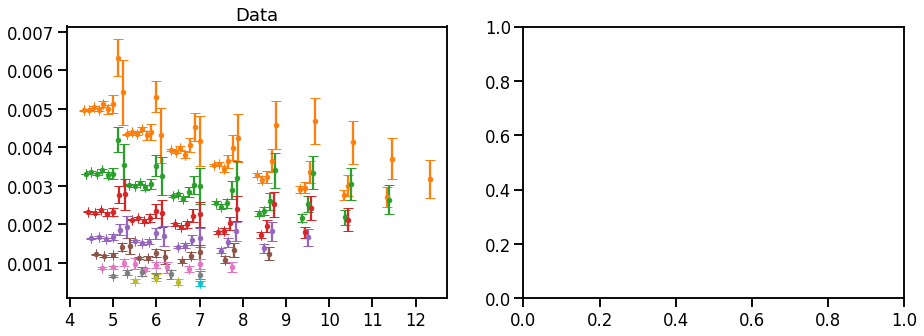

In [55]:

with sns.plotting_context("talk"):
    
    mask =\
        (data['dt+'] >= 4) &\
        (data['v'] >= 1)
#     mask =\
#         (data['ratio'].apply(analysis.n2s).apply(np.abs) < 0.5) &\
#         (data['dt+'] > 4) 
    
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, axarr = plt.subplots(ncols=2, figsize=(15, 5), sharey=False)
    # Plot data
    ax = axarr[0]
    for (v, subdf) in data[mask].groupby('|v|'):
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=colors[v])
    ax.set_title("Data")
        
    # Plot fit result
    x = data[mask][['t-','v','dt+']].values
    yfit = global_model(x, fit.p)
    tmp = pd.DataFrame(data[mask][['dt-','t-','v','|v|','dt+']])
    tmp['ratio'] = yfit
    
    ax = axarr[0]
    for (v, subdf) in tmp.groupby('|v|'):
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax, x=x, y=y, fmt='o', ms=5, capsize=5,
                     markerfacecolor='none', color='k', alpha=0.5)
    
    # Plot residuals
    ax = axarr[1]
    ydata = data[mask]['ratio'].values
    yfit = tmp['ratio'].values
    y = (gv.mean(ydata) - gv.mean(yfit)) / gv.sdev(ydata)
    sns.histplot(y, ax=ax, stat='probability', bins=20, label='Fit residuals')
    
    ynormal = np.random.normal(size=len(y))
    sns.histplot(ynormal, ax=ax, stat='probability', bins=20, label='Control')
    ax.legend()


In [56]:
np.min(data['dt+'])

3

Text(0, 0.5, 'Ratio $C_4/C_2$')

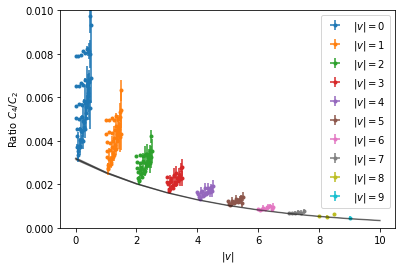

In [57]:


fig, ax = plt.subplots(1)

mask =\
    (data['dt+'] >= 4) &\
    (data['v'] >= 0)

for v, subdf in data[mask].groupby('|v|'):
#     subdf = subdf.sort_values(by=['t-','dt+'])
    y = subdf['ratio']
    x = v + np.linspace(0, 0.5, num=len(y))
    plt.errorbar(ax, x, y, fmt='.', label=r"$|v|=$"+str(v))
    

v = np.arange(0, 11)
y = fit.p['a0']*np.exp(-v*fit.p['E0'])
plt.errorbar(ax, x=v, y=y, color='k', bands=True, alpha=0.5)

ax.set_ylim(0, 0.01)
ax.legend()
ax.set_xlabel(r"$|v|$")
ax.set_ylabel("Ratio $C_4/C_2$")

### Stability analysis

In [58]:
def run_fit(df, mode, expand=1):
    assert mode in ('full', 'basic', 'extra'), f"Unexpected mode '{mode}'"

    y = df['ratio'].values
    if mode == 'extra':
        x = df[['t-','v','dt+']].values
    else:
        # Model exponential time dependence on the sourc-sink separation 'dt'
        x = df[['dt','v','dt+']].values
    full = True if mode in ('full', 'extra') else False
    prior = build_prior(df, mode=mode, expand=expand)
    fcn = global_model_full if full else global_model    
    fit = lsqfit.nonlinear_fit(data=(x, {'ratio':y}), fcn=fcn, prior=prior)
    yfit = fcn(x, fit.p)['ratio']
    tmp = pd.DataFrame(df[['dt-','t-','v','|v|','dt+']])
    tmp['ratio'] = yfit 
    weight = aic_model_probability(fit)
    result = {
        'expand': expand,
        'p': fit.p,
        'chi2': fit.chi2, 
        'chi2_aug': compute_chi2(fit, augmented=True),
        'chi2_data': compute_chi2(fit, augmented=False),
        'chi2/dof': fit.chi2/fit.dof,
        'dof': fit.dof,
        'nparam': len(fit.p),
        'Q': fit.Q,
        'weight': weight,
        'aic': -2*np.log(weight),
        'fit_df': tmp,
        'mask': mask,
        'full': full,
        'nparams': count_nparams(fit.p),
        'ndata': count_ndata(fit.y),
    }
    for k in fit.p:
        key = strip_log(k)
        result[key] = fit.p[key]     
    return result

In [59]:
def strip_log(key):
    key_template = re.compile(r"^log\((.+)\)$")
    match = key_template.match(key)
    if match:
        return match.groups()[0]
    return key

##############################
# Run generic scan over cuts #
##############################

dtp_cuts = np.arange(3, 8)
v_cuts = np.arange(2, 6)
# tm_cuts = np.arange(-13, -4, 1)
tm_cuts = [-14]
results_base = []
for dtp_cut, v_cut, tm_cut in tqdm(itertools.product(dtp_cuts, v_cuts, tm_cuts)):
    mask = (data['dt+'] >= dtp_cut) & (data['|v|'] >= v_cut) & (data['t-'] >= tm_cut) &\
        (data['ratio'].apply(analysis.n2s) < 0.125) 
    if len(data[mask]) < 10:
        continue
    for mode in ['full', 'basic', 'extra']:
        result = run_fit(data[mask], mode=mode, expand=1.0)
        result['dtp_cut'] = dtp_cut
        result['v_cut'] = v_cut
        result['tm_cut'] = tm_cut
        result['mode'] = mode
        result['nbunch'] = None  # not applicable for base scan
        result['shift'] = None   # not applicable for base scan
        results_base.append(result)

20it [00:17,  1.16it/s]


In [60]:
assert False, "Stop"
############################################
# Do minor variations on the preferred cut #
############################################

results_extra = []
for v_cut, dtp_cut in [(2,3), (3,3), (3,4)]:   
    # dtp_cut = 3
    # v_cut = 2
    tm_cut = -14
    mask = (data['dt+'] >= dtp_cut) & (data['|v|'] >= v_cut) & (data['t-'] >= tm_cut) &\
        (data['ratio'].apply(analysis.n2s) < 0.125)
    print(len(data[mask]))

    vkeep = np.sort(data[mask]['v'].unique())

    for shift in [1,]:
        for nbunch in [1,2]:
            print(f" {nbunch} ".center(40, "#"))
            for idx in range(len(vkeep)//nbunch):
                start = nbunch*idx
                drop = data['v'].isin(vkeep[start: start+nbunch]) & (data['dt+'] < dtp_cut + shift)    
                keep = ~drop
                if len(data[mask & keep]) < 200:
                    continue
                for mode in ['basic', 'full', 'extra']:
                    result = run_fit(data[mask & keep], mode=mode)
                    result['dtp_cut'] = dtp_cut
                    result['v_cut'] = v_cut
                    result['tm_cut'] = tm_cut
                    result['nbunch'] = nbunch
                    result['mode'] = mode
                    result['shift'] = shift
                    results_extra.append(result)


AssertionError: Stop

In [61]:
#######################
# Collect all results #
#######################

results = pd.DataFrame(results_base)# + results_extra)
results['weight'] = results['weight'] / results['weight'].sum()

mask = results['shift'].isna()
results.loc[mask, 'shift'] = 0



In [62]:
results[['v_cut','dtp_cut','chi2/dof','chi2','chi2_aug', 'chi2_data','ndata','nparams','weight','aic','mode']]

,v_cut,dtp_cut,chi2/dof,chi2,chi2_aug,chi2_data,ndata,nparams,weight,aic,mode
0,2,3,0.927823,222.677624,222.677624,215.406158,240,20,9.999816e-01,-217.322376,full
1,2,3,1.097822,263.477302,263.477302,263.382509,240,11,1.119708e-05,-194.522698,basic
2,2,3,1.026461,246.350733,246.350733,245.142720,240,20,7.235051e-06,-193.649267,extra
3,3,3,0.867651,145.765448,145.765448,144.768422,168,18,1.998228e-14,-154.234552,full
4,3,3,0.971715,163.248048,163.248048,163.021265,168,10,9.521437e-15,-152.751952,basic
5,3,3,0.953293,160.153294,160.153294,159.139571,168,18,1.500942e-17,-139.846706,extra
6,4,3,0.775067,86.807559,86.807559,85.352218,112,16,4.480081e-25,-105.192441,full
7,4,3,1.022590,114.530048,114.530048,113.710478,112,9,4.693376e-28,-91.469952,basic
8,4,3,1.020066,114.247365,114.247365,111.370214,112,16,4.929556e-31,-77.752635,extra
9,5,3,0.706595,49.461662,49.461662,47.983882,70,14,2.449431e-34,-62.538338,full


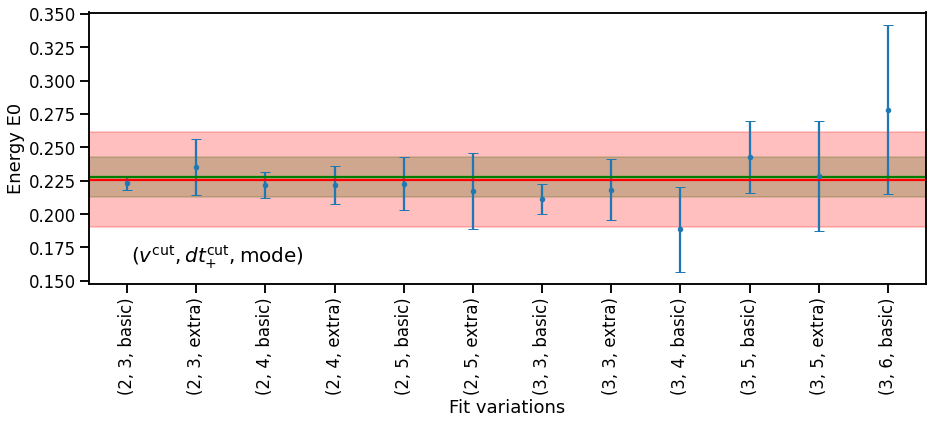

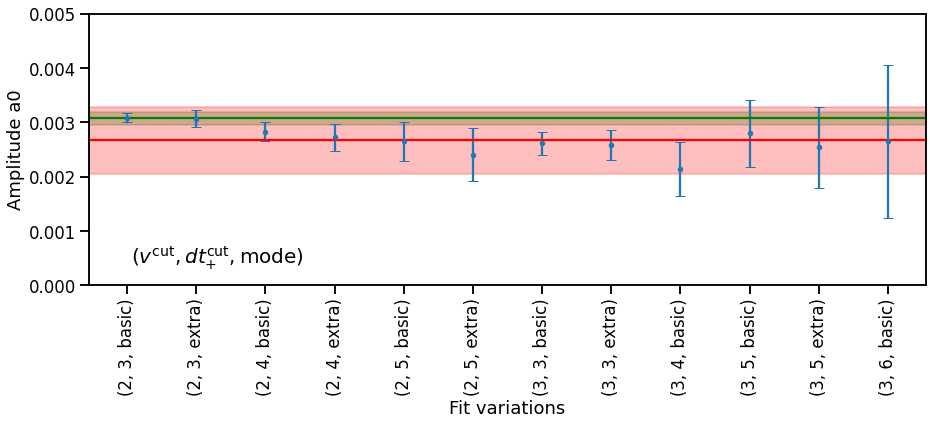

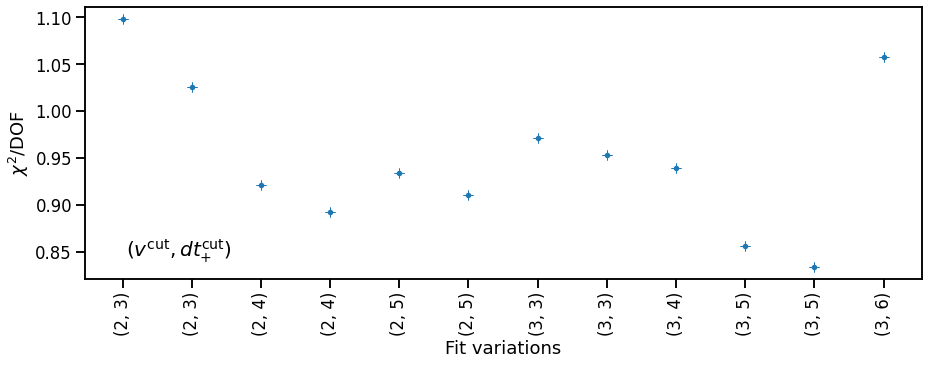

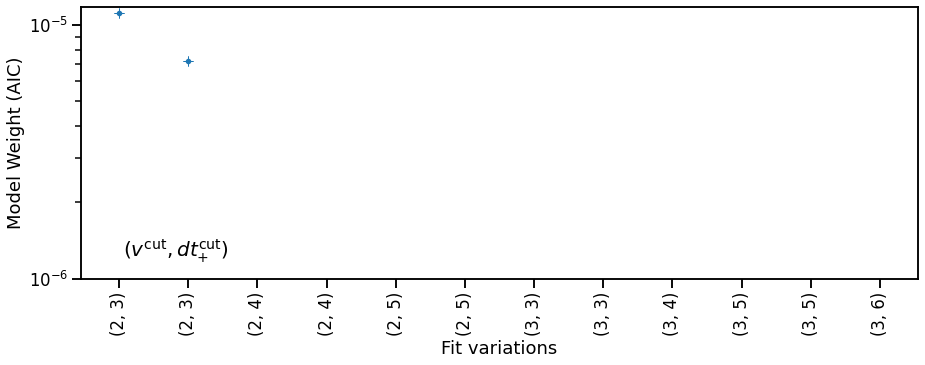

In [63]:
mask =\
    ~results['chi2/dof'].isna() &\
    (results['chi2/dof'] < 1.5) &\
    (results['E0'].apply(analysis.n2s) < 0.25) &\
    (results['mode'] != 'full')
# &\     (results['shift'].isna())
# (results['dtp_cut'] == 4)
# &\
#     (results['v_cut'] == 3) &\
#     (results['dtp_cut'] == 4)
#     (results['nbunch'].isna()) &\
#     (results['chi2/dof'] > 0.75) &\
#     (results['weight'] > 1e-20)


df = results[mask].sort_values(by=['shift','v_cut', 'dtp_cut'])

weights = df['weight'].values

def decorrelate(gvarr):
    def _separate(agvar):
        return gv.mean(agvar), gv.sdev(agvar)
    return np.array([gv.gvar(*_separate(elt)) for elt in gvarr])


def add_text(ax, text):
    ax.text(0.05, 0.05, 
            text,
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='k', fontsize=20)

with sns.plotting_context("talk"):


    fig, ax = plt.subplots(1, figsize=(15, 5))
    y = df['E0'].values
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)
    E0avg = stats.model_avg(y, weights)
#     E0pick = lsqfit.wavg(y)
    E0pick = stats.model_avg(y, np.ones(len(y)))
    E0last = y[-1]
    plt.axhline(ax, y=E0avg, color='g')
    plt.axhline(ax, y=E0pick, color='r')
#     ax.set_ylim(0.1, 0.3)
    ax.set_ylabel("Energy E0")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut','mode']].apply(lambda args: "({0}, {1}, {2})".format(*args), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut}, {\rm mode})$")
        
    fig, ax = plt.subplots(1, figsize=(15, 5))
    y = df['a0'].values
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)
    a0avg = stats.model_avg(y, weights)
#     a0pick = lsqfit.wavg(y)
    a0pick = stats.model_avg(y, np.ones(len(y)))
    a0last = y[-1]
    plt.axhline(ax, y=a0avg, color='g')
    plt.axhline(ax, y=a0pick, color='r')
    ax.set_ylim(0, 0.005)
    ax.set_ylabel("Amplitude a0")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut','mode']].apply(lambda args: "({0}, {1}, {2})".format(*args), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut}, {\rm mode})$")
    
    fig, ax = plt.subplots(1, figsize=(15, 5))
    y = df['chi2/dof']
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)
    ax.set_ylabel(r"$\chi^2/{\rm DOF}$")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut']].apply(lambda pair: "({0}, {1})".format(*pair), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut})$")
    
    fig, ax = plt.subplots(1, figsize=(15, 5))
    y = df['weight']
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)

    ax.set_ylabel("Model Weight (AIC)")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut']].apply(lambda pair: "({0}, {1})".format(*pair), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut})$")
    ax.set_ylim(1e-6)
    ax.set_yscale("log")

In [64]:
df = pd.DataFrame(results_extra)
df['weight'] = df['weight'] / df['weight'].sum()


mask =\
    ~df['chi2/dof'].isna() &\
    (df['chi2/dof'] < 1.5) &\
    (df['E0'].apply(analysis.n2s) < 0.25) &\
    (df['v_cut'] == 2)
#     (results['shift'].isna())
# (results['dtp_cut'] == 4)
# &\
#     (results['v_cut'] == 3) &\
#     (results['dtp_cut'] == 4)
#     (results['nbunch'].isna()) &\
#     (results['chi2/dof'] > 0.75) &\
#     (results['weight'] > 1e-20)


df = df[mask].sort_values(by=['v_cut', 'dtp_cut'])

weights = df['weight'].values

def add_text(ax, text):
    ax.text(0.05, 0.05, 
            text,
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='k', fontsize=20)

with sns.plotting_context("talk"):


    fig, ax = plt.subplots(1, figsize=(25, 5))
    y = df['E0'].values
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)
    E0avg = stats.model_avg(y, weights)
    E0pick = lsqfit.wavg(y)
    E0last = y[-1]
    plt.axhline(ax, y=E0avg, color='g')
#     plt.axhline(ax, y=E0pick, color='r')
#     ax.set_ylim(0.1, 0.3)
    ax.set_ylabel("Energy E0")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut','mode']].apply(lambda args: "({0}, {1}, {2})".format(*args), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut}, {\rm mode})$")
        
    fig, ax = plt.subplots(1, figsize=(25, 5))
    y = df['a0'].values
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)
    a0avg = stats.model_avg(y, weights)
    a0pick = lsqfit.wavg(y)
    a0last = y[-1]
    plt.axhline(ax, y=a0avg, color='g')
#     plt.axhline(ax, y=a0pick, color='r')
    ax.set_ylim(0, 0.005)
    ax.set_ylabel("Amplitude a0")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut','mode']].apply(lambda args: "({0}, {1}, {2})".format(*args), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut}, {\rm mode})$")
    
    fig, ax = plt.subplots(1, figsize=(15, 5))
    y = df['chi2/dof']
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)
    ax.set_ylabel(r"$\chi^2/{\rm DOF}$")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut']].apply(lambda pair: "({0}, {1})".format(*pair), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut})$")
    
    fig, ax = plt.subplots(1, figsize=(15, 5))
    y = df['weight']
    x = np.arange(len(y))
    plt.errorbar(ax, x, y, fmt='.', capsize=5)

    ax.set_ylabel("Model Weight (AIC)")
    ax.set_xlabel("Fit variations")
    ax.set_xticks(x)
    xticklabels = df[['v_cut','dtp_cut']].apply(lambda pair: "({0}, {1})".format(*pair), axis=1)
    ax.set_xticklabels(xticklabels, rotation=90)
    add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut})$")
    ax.set_ylim(1e-6)
    ax.set_yscale("log")

NameError: name 'results_extra' is not defined

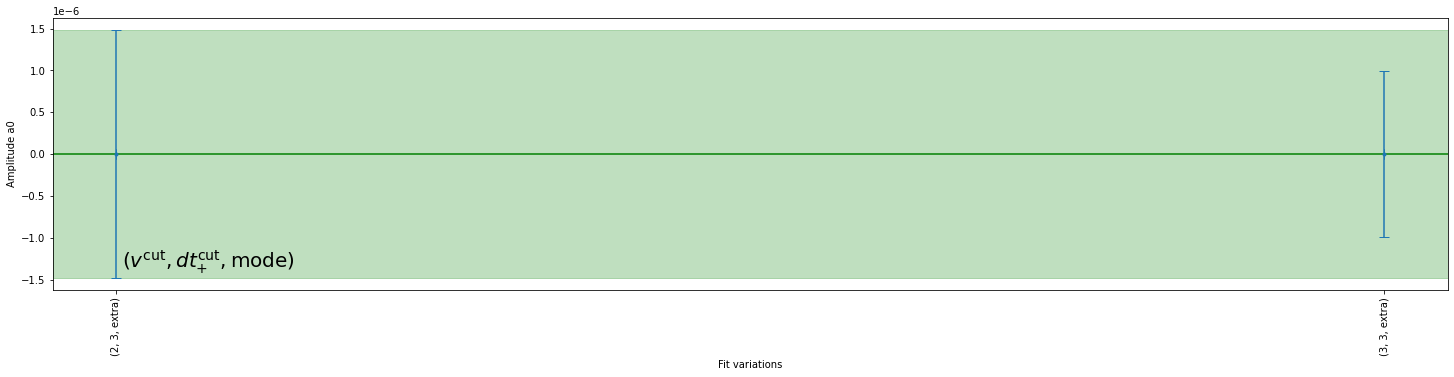

In [65]:
fig, ax = plt.subplots(1, figsize=(25, 5))
key = 'am:9'
mask = ~df[key].isna()
y = df[mask][key].values
x = np.arange(len(y))
plt.errorbar(ax, x, y, fmt='.', capsize=5)
a0avg = stats.model_avg(y, weights[mask])
# a0pick = lsqfit.wavg(y)
# a0last = y[-1]
plt.axhline(ax, y=a0avg, color='g')
# ax.set_ylim(-0.1, 0.1)
ax.set_ylabel("Amplitude a0")
ax.set_xlabel("Fit variations")
ax.set_xticks(x)
xticklabels = df[mask][['v_cut','dtp_cut','mode']].apply(lambda args: "({0}, {1}, {2})".format(*args), axis=1)
ax.set_xticklabels(xticklabels, rotation=90)
add_text(ax, r"$(v^{\rm cut}, dt_{+}^{\rm cut}, {\rm mode})$")






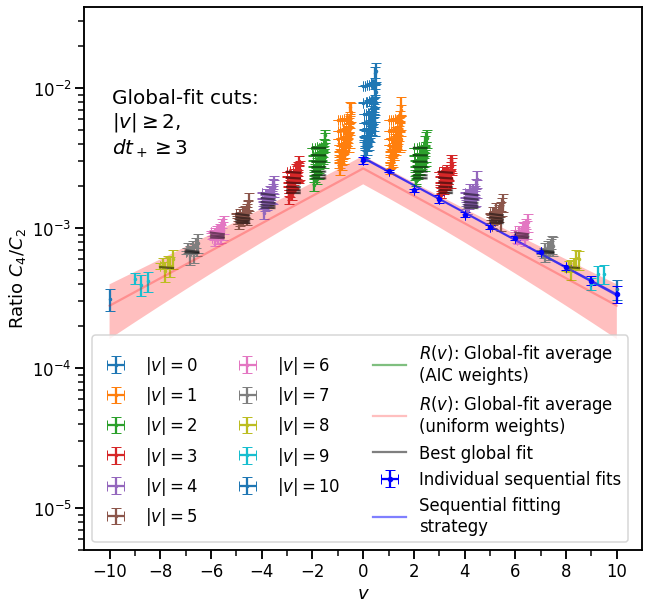

In [66]:
# colors = sns.color_palette(n_colors=len(data['|v|'].unique()))
colors = sns.color_palette(n_colors=20)

with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, figsize=(10, 10))

    mask =\
        (data['dt+'] >= 0) &\
        (data['|v|'] >= 0)

    for v, subdf in data[mask].groupby('v'):
        y = subdf['ratio']
        x = v + np.linspace(0, 0.5, num=len(y))
        
        label = r"$|v|=$"+str(v) if v >= 0 else None
            
        plt.errorbar(ax, x, y, fmt='.', capsize=5, ms='5',
                     color=colors[np.abs(v)],
                     label=label)


    v = np.arange(-10, 11)
    y = a0avg*np.exp(-np.abs(v)*E0avg)
    plt.errorbar(ax, x=v, y=y, color='g', bands=True, alpha=0.5,
                 label=r'$R(v)$: Global-fit average'+'\n(AIC weights)')

    y = a0pick*np.exp(-np.abs(v)*E0pick)
    plt.errorbar(ax, x=v, y=y, color='r', bands=True, alpha=0.25,
                 label=r'$R(v)$: Global-fit average'+'\n(uniform weights)')
    
    best = (results.index == results['weight'].idxmax())
#     y = results[best]['a0'].item()*np.exp(-np.abs(v)*results[best]['E0'].item())
#     plt.errorbar(ax, x=v, y=y, color='orange', bands=True, alpha=0.5, label=r'$R(v)$ Best fit')
    fit_df = results[best]['fit_df'].item()
    first = True
    for (v, dtp), subdf in fit_df.groupby(['v','dt+']):

        y = subdf['ratio'].values
        x = v + np.linspace(0, 0.5, num=len(y))
        offset = 0 if v > 0 else 0.5
        label = 'Best global fit' if first else None
        plt.errorbar(ax=ax, x=x, y=y, bands=True, color='k', alpha=0.5, label=label)
        first = False
        
    y = single_best['plateau']
    x = single_best['v']
    plt.errorbar(ax=ax, x=x, y=y, color='blue', fmt='.', capsize=5, label='Individual sequential fits')
    
    y = fit_reduced['ratio']
    x = fit_reduced['v']
    plt.errorbar(ax=ax, x=x, y=y, color='blue', bands=True, alpha=0.5, label='Sequential fitting\nstrategy')
        
        
    label_cuts = (
        "Global-fit cuts:\n"
        r"$|v|\geq$" + str(results[best]['v_cut'].item()) + ",\n"
        r"$dt_+\geq$" + str(results[best]['dtp_cut'].item())
    )
    
    ax.legend(ncol=3)#, bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel(r"$v$")
    ax.set_xticks(np.arange(-10, 10+1, 1), minor=True)
    ax.set_xticks(np.arange(-10, 10+1, 2), minor=False)
    
    ax.set_ylabel("Ratio $C_4/C_2$")
    ax.set_yscale("log")
    ax.set_ylim(bottom=5e-6)
    
    ax.text(0.05, 0.85, 
            label_cuts,
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='k', fontsize=20)
    
    today = datetime.date.today().strftime('%Y%m%d')
#     fig.savefig(f"Figures/global_fit_{today}.pdf")
    

### Integrated results

In [67]:
fit_alternative.p['a0'] / fit_alternative.p['E0']

0.01410(22)

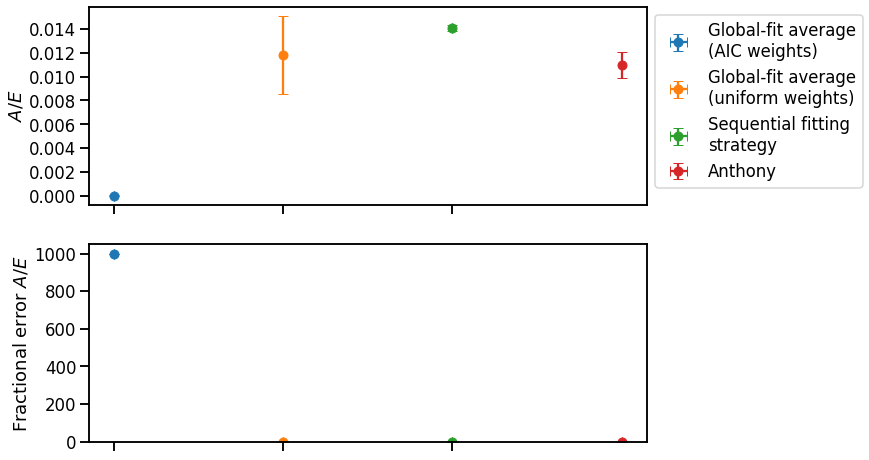

In [68]:
with sns.plotting_context('talk'):

    fig, axarr = plt.subplots(nrows=2, figsize=(10, 8))
    
    y = a0avg/E0avg
    x = 0
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Global-fit average\n(AIC weights)")
    plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Global-fit average\n(AIC weights)")

    y = a0pick/E0pick
    x = 1
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Global-fit average\n(uniform weights)")
    plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Global-fit average\n(uniform weights)")

    p = fit_alternative.p
    y = p['a0']/p['E0']
    x = 2
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Sequential fitting\nstrategy")
    plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Sequential\nfitting strategy")    

    y = gv.gvar(0.011, 0.1*0.011)
    x = 3
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Anthony")
    plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Anthony")    

    
    
    for ax in axarr:
    
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels([])
    
    axarr[0].set_ylabel(r"$A/E$")
    axarr[1].set_ylabel(r"Fractional error $A/E$")
    axarr[1].set_ylim(bottom=0)
    axarr[0].legend(bbox_to_anchor=(1,1))

240
240
240
168
168
168
168
168
168


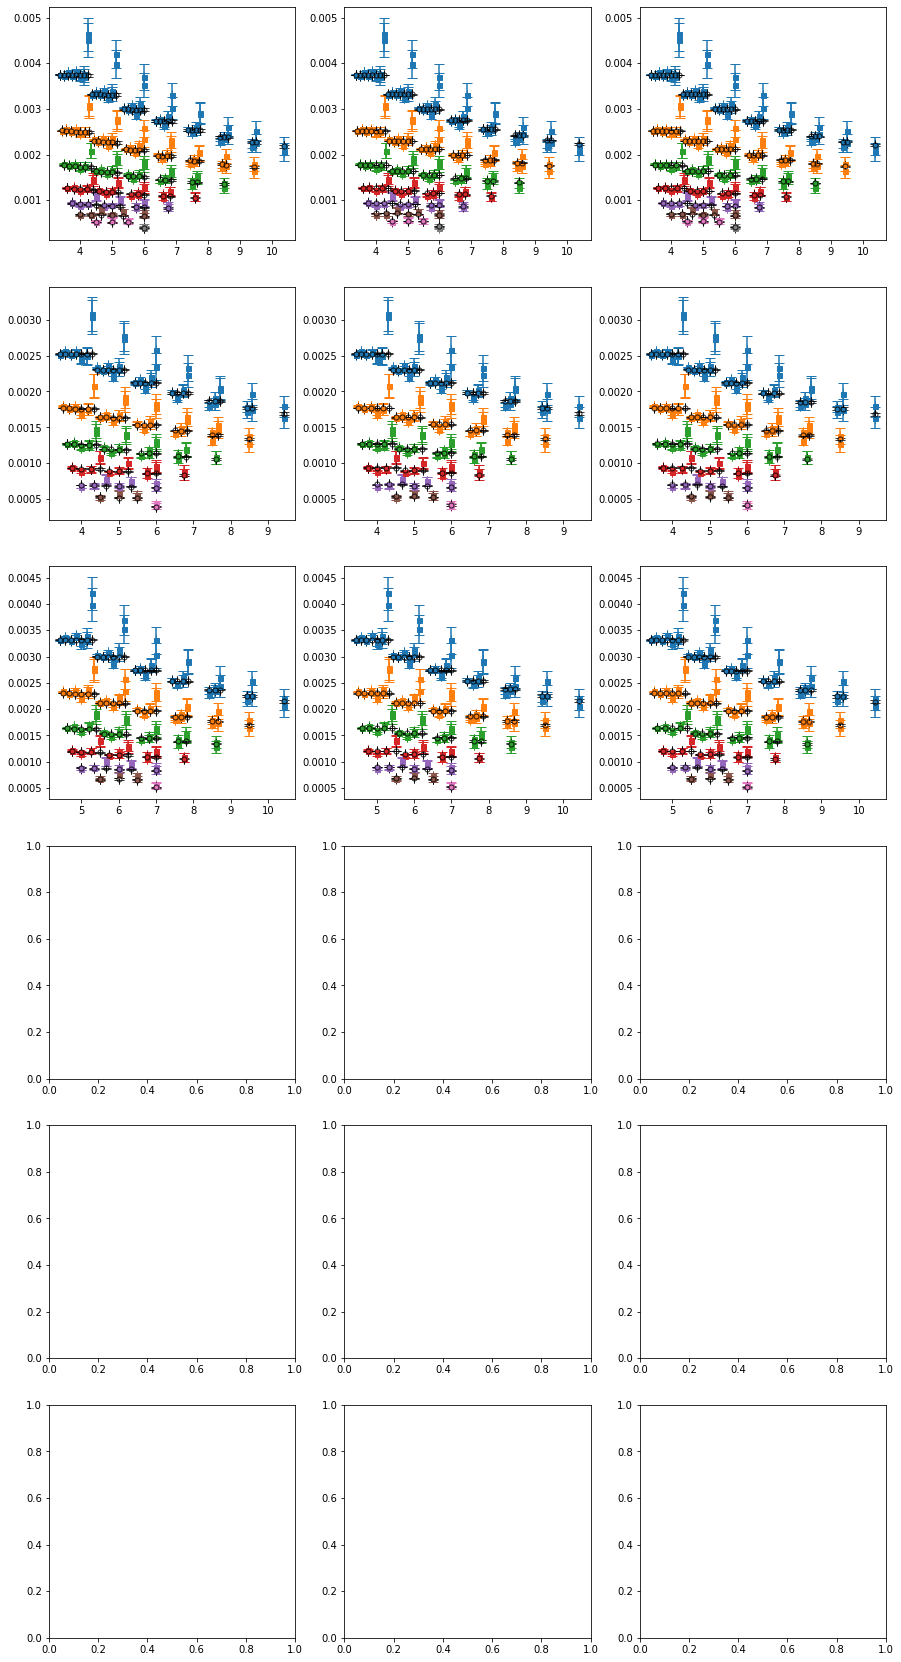

In [69]:
keep =\
    ~results['chi2/dof'].isna() &\
    (results['weight'] > 1e-20)

fig, axarr = plt.subplots(ncols=3, nrows=6, figsize=(3*5, 6*5))

for (_, row), ax in zip(results[keep].iterrows(), np.ravel(axarr)):

    tmp = row['fit_df']
    mask = row['mask']
    print(len(data[mask]))
    for (v, subdf) in data[mask].groupby('|v|'):
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax, x=x, y=y, fmt='s', ms=5, capsize=5)
    
    for (v, subdf) in tmp.groupby('|v|'):
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5
        plt.errorbar(ax=ax, x=x, y=y, fmt='o', ms=5, capsize=5,
                     markerfacecolor='none', color='k', alpha=0.5)    


### Estimating energies/amplitudes

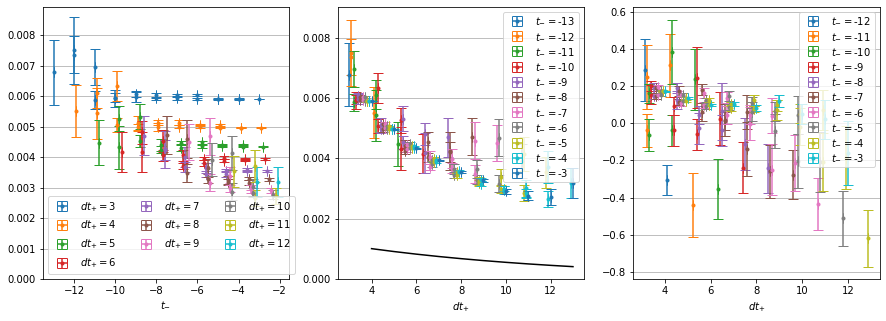

In [70]:
mask =\
    (data['|v|'] == 1)
# &\
#     (data['t-'] > -10)


fig, axarr = plt.subplots(ncols=3, figsize=(15, 5), sharey=False)

# Fix dt+, vary t- (expect nearly constant)
ax = axarr[0]
for idx, (dtp, subdf) in enumerate(data[mask].groupby('dt+')):
    y = subdf['ratio']
    x = subdf['t-'] + idx*0.1
    plt.errorbar(ax, x, y, fmt='.', label=r"$dt_{+}=$"+f"{dtp}", capsize=5)
ax.set_xlabel(r"$t_{-}$")
ax.legend(ncol=3)
ax.set_ylim(bottom=0)
ax.grid(axis='y')

# Fix t0, vary dt+ (expect approximately exponential decay)
ax = axarr[1]
for idx, (tm, subdf) in enumerate(data[mask].groupby('t-')):
    y = subdf['ratio']
    x = subdf['dt+'] + idx*0.1
    plt.errorbar(ax, x, y, fmt='.', label=r"$t_{-}=$"+f"{tm}", capsize=5)
    
x = np.arange(4, 14)
y = 0.0015*np.exp(-0.1*x)
plt.errorbar(ax, x, y, color='k')
    
ax.legend()
ax.set_xlabel(r"$dt_{+}$")
ax.grid(axis='y')




ax = axarr[2]
for idx, (tm, subdf) in enumerate(data[mask].groupby('t-')):
    if len(subdf) < 2:
        continue
    y = subdf['ratio'].values
    m = np.log(y[:-1]/y[1:])        
    x = subdf['dt+'].values[:-1] + idx*0.1
    plt.errorbar(ax, x, m, fmt='.', label=r"$t_{-}=$"+f"{tm}", capsize=5)
ax.legend()
ax.set_xlabel(r"$dt_{+}$")
ax.grid(axis='y')

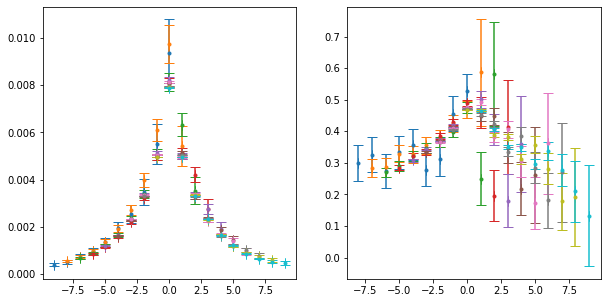

In [71]:
fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
for (tm, dtp), subdf in data.groupby(['t-', 'dt+']):
    
    if len(subdf) != 10:
        continue
    
    
    x = subdf['v'].values
    y = subdf['ratio'].values
    plt.errorbar(axarr[0], x, y, fmt='.', capsize=5)

    if len(subdf) < 2:
        continue
    m = np.log(y[:-1]/y[1:])
    m *= np.sign(m)
    plt.errorbar(axarr[1], x[1:], m, fmt='.', capsize=5)
    


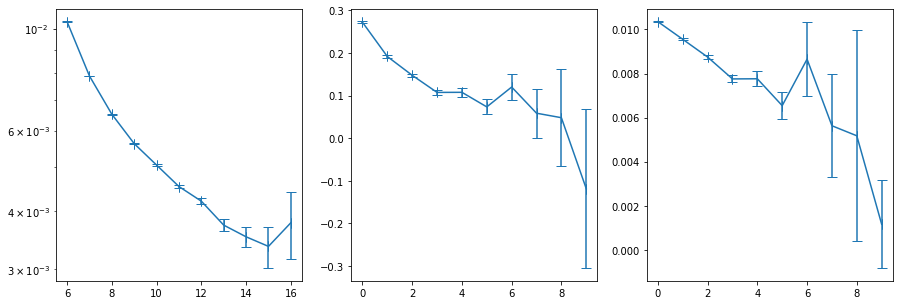

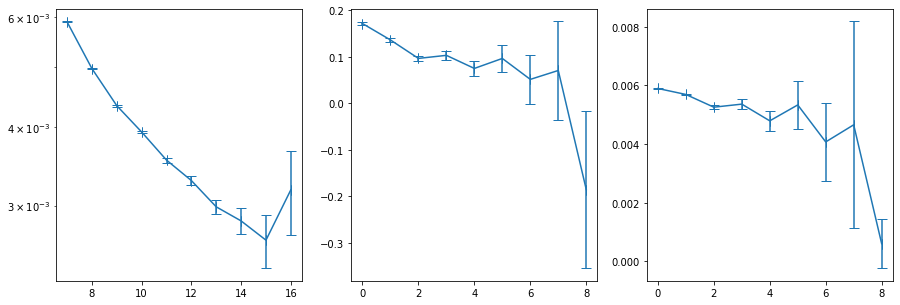

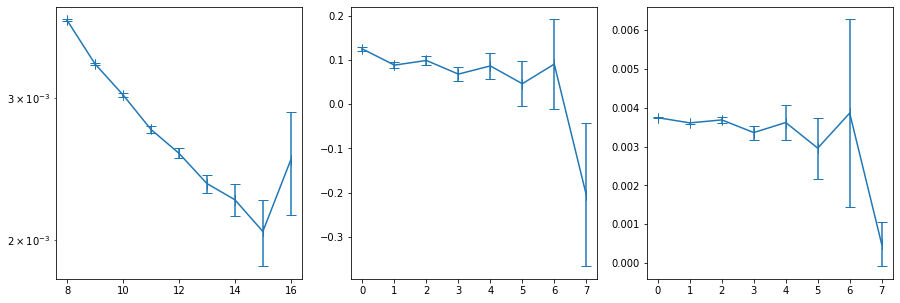

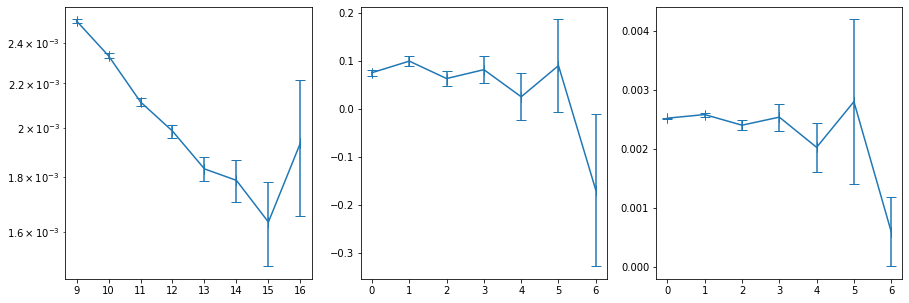

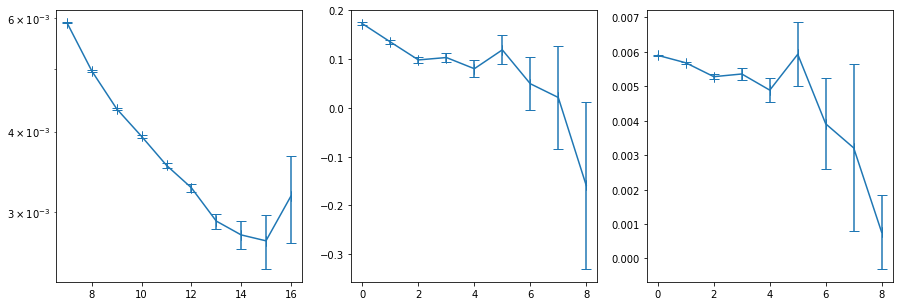

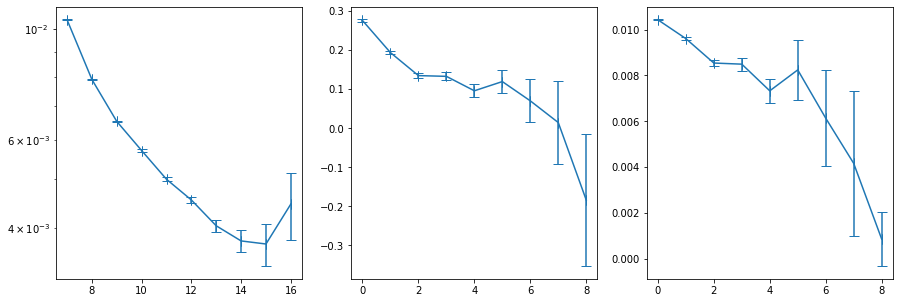

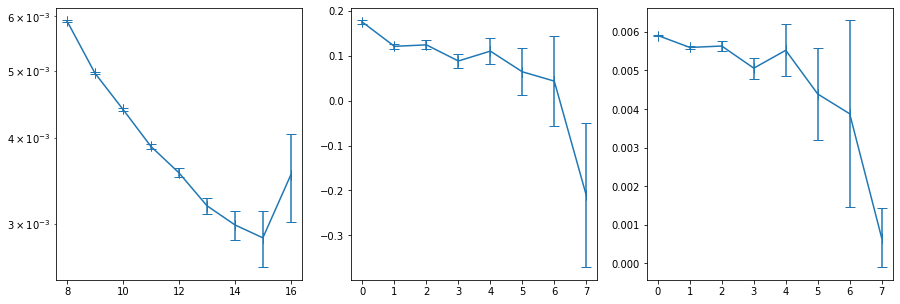

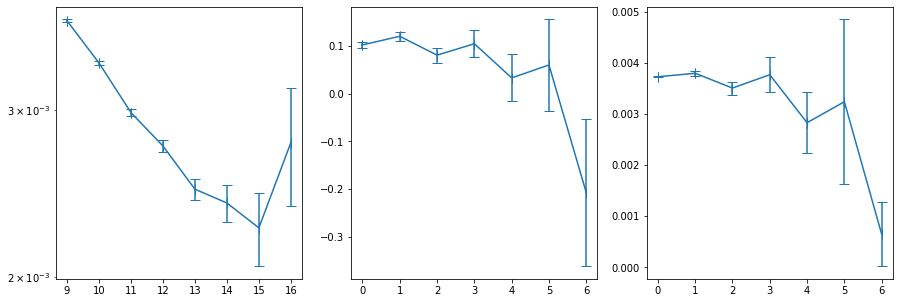

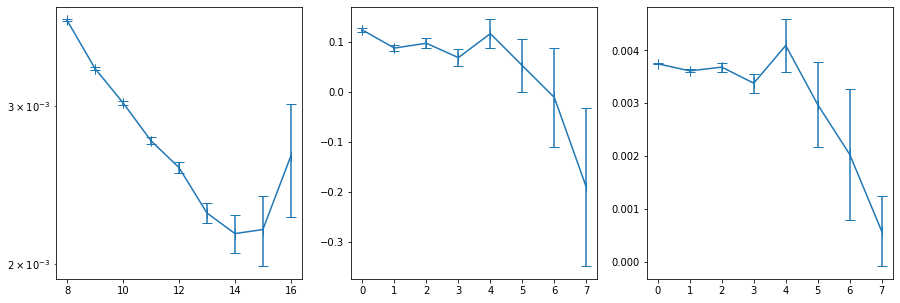

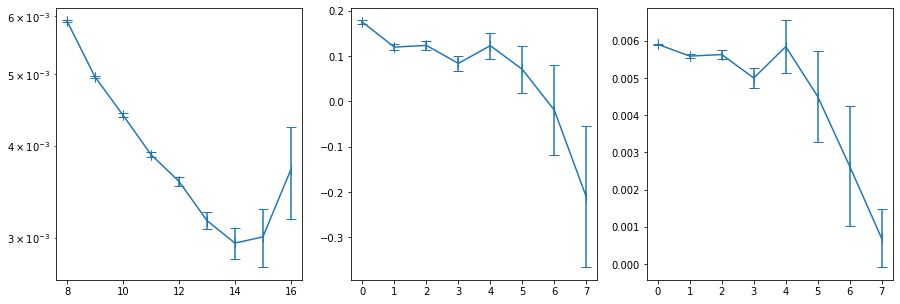

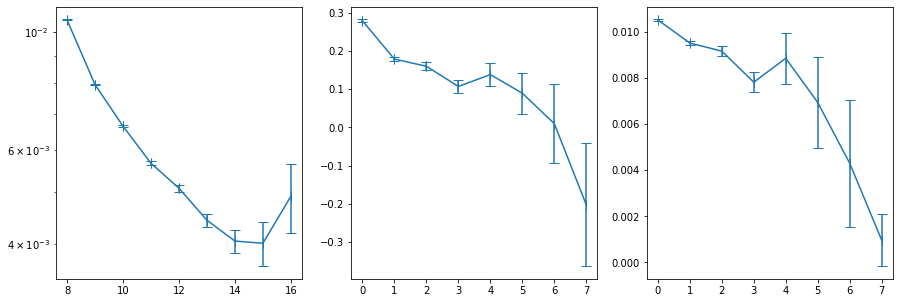

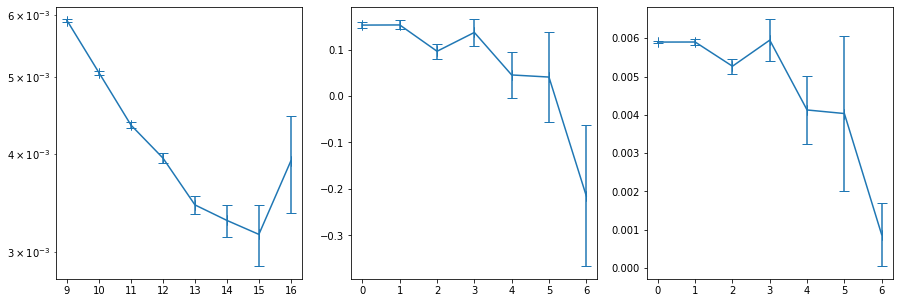

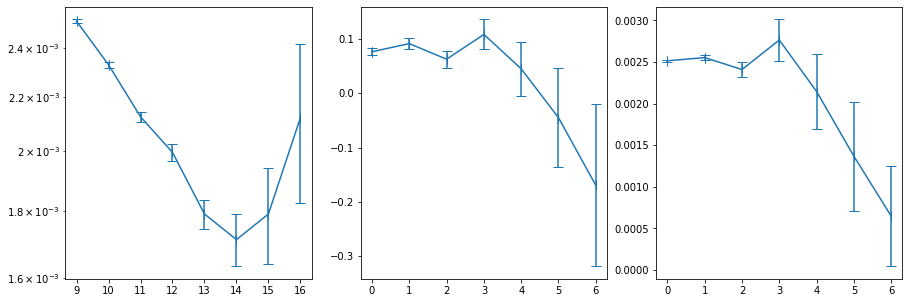

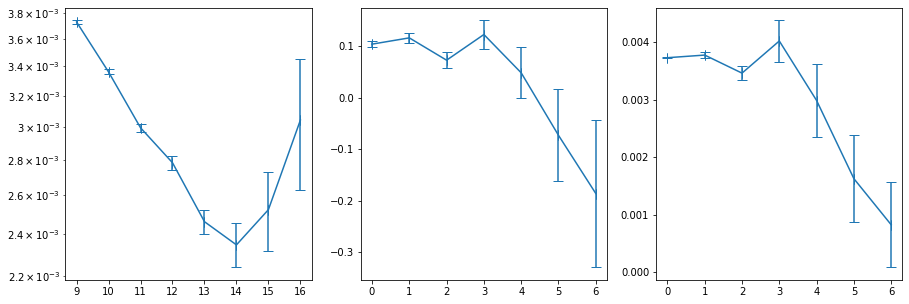

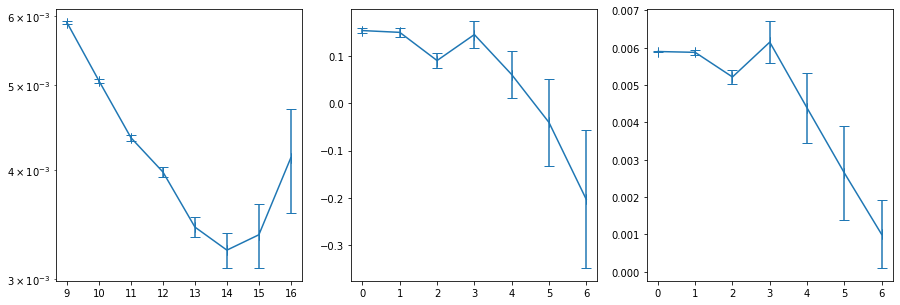

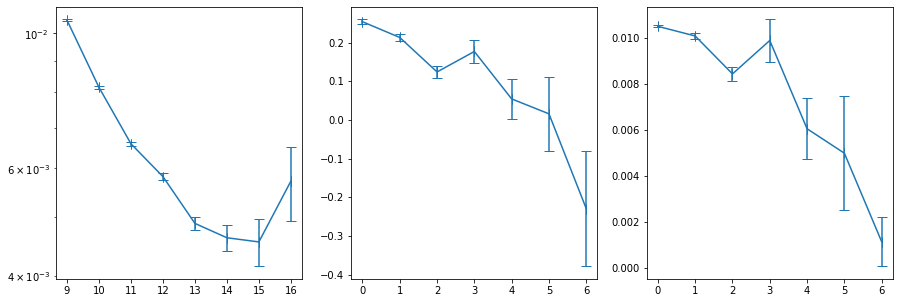

In [72]:

for (top1, top2), df in data.groupby(['top1', 'top2']):
    if len(df) < 8:
        continue

    fig, axarr = plt.subplots(ncols=3, figsize=(15, 5))
    x = df['tsnk'].values
    y = df['ratio'].values
    plt.errorbar(axarr[0], x, y, fmt='-', capsize=5)
    
    y = np.log(y[:-1]/y[1:])
    x = np.arange(len(y))
    plt.errorbar(axarr[1], x, y, fmt='-', capsize=5)    

    y = df['ratio'].values    
    m = np.log(y[:-1]/y[1:])
    x = np.arange(len(y[:-1]))
    y = np.exp(+m*x)*y[:-1]
    
    plt.errorbar(axarr[2], x, y, fmt='-', capsize=5)    

        
    
    
    axarr[0].set_yscale("log")

## Summation Method

### Data Wrangling

In [73]:
sumdata = []
deltas = [3,4,5,6]

tmp = {}
for tsnk, df in data.groupby('tsnk'):
    for dsrc, dsnk in itertools.product(deltas, repeat=2):
        mask =\
            (df['top1'] > dsrc) & (df['top1'] < (tsnk - dsnk)) &\
            (df['top2'] > dsrc) & (df['top2'] < (tsnk - dsnk))            
        if len(df[mask]) > 0:
            if (dsrc, dsnk) not in tmp:
                tmp[(dsrc, dsnk)] = []
            tmp[(dsrc, dsnk)].append({
                'tsnk': tsnk,
                f'{dsrc}:{dsnk}': df[mask]['ratio'].sum(),
            })
            
for key in tmp:
    tmp[key] = pd.DataFrame(tmp[key])
sumdata = reduce(lambda x, y: pd.merge(x, y, on='tsnk', how='outer'), tmp.values())

            

In [74]:

deltas = [3,4,5,6]

tmp = []
for tsnk, df in data.groupby('tsnk'):
    for dsrc, dsnk in itertools.product(deltas, repeat=2):
        mask =\
            (df['top1'] > dsrc) & (df['top1'] < (tsnk - dsnk)) &\
            (df['top2'] > dsrc) & (df['top2'] < (tsnk - dsnk))            
        if len(df[mask]) == 0:
            continue
        tmp.append({
            'tsnk': tsnk,
            'dsrc': dsrc,
            'dsnk': dsnk,
            'ratio': df[mask]['ratio'].sum(),            
        })
        
        
sumdata2 = pd.DataFrame(tmp)



### Viewing data

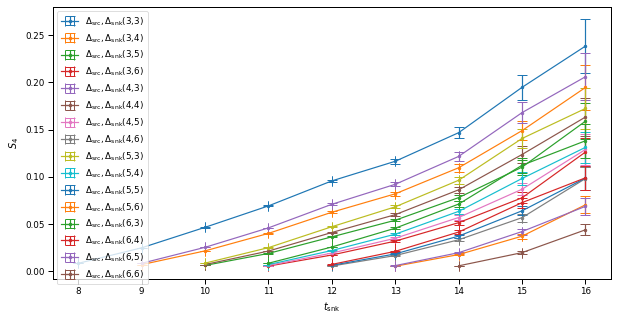

In [75]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(ncols=1, figsize=(10, 5))

    for dsrc, dsnk in itertools.product([3,4,5,6], repeat=2):
        x = sumdata['tsnk'].values
        y = sumdata[f'{dsrc}:{dsnk}'].values
        plt.errorbar(ax, x, y, fmt='.-', capsize=5,
                     label=r'$\Delta_{\rm src}, \Delta_{\rm snk}$'+f'({dsrc},{dsnk})')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # x = np.linspace(0, 16)
    # y = -0.15 + 0.018*x
    # plt.errorbar(ax, x, y, color='k')

    # x = np.linspace(0, 16)
    # y = -0.28 + 0.026*x
    # plt.errorbar(ax, x, y)

    # x = np.linspace(0, 16)
    # y = -0.32 + 0.026*x
    # plt.errorbar(ax, x, y)

    # x = np.linspace(0, 16)
    # y = -0.38 + 0.026*x
    # plt.errorbar(ax, x, y)



    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(r"$t_{\rm snk}$")
    ax.set_ylabel(r"$S_4$")
    ax.legend()

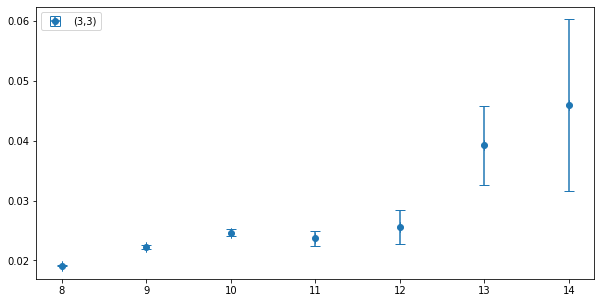

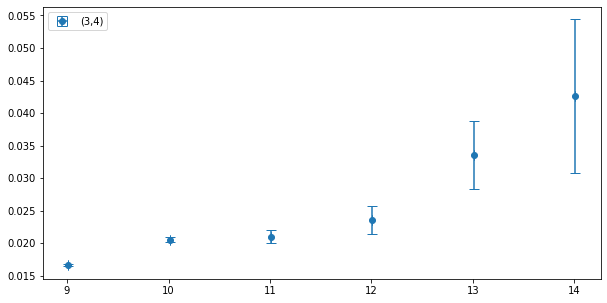

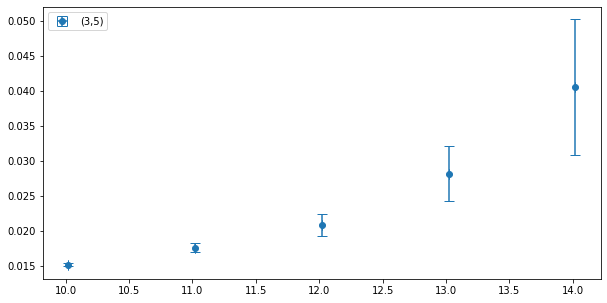

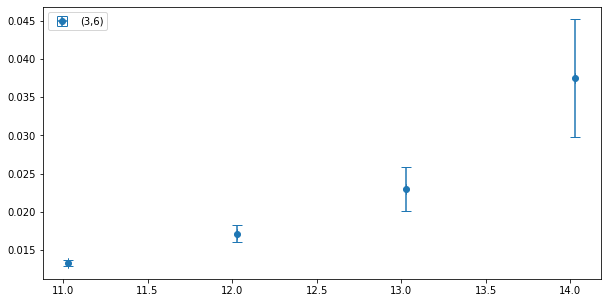

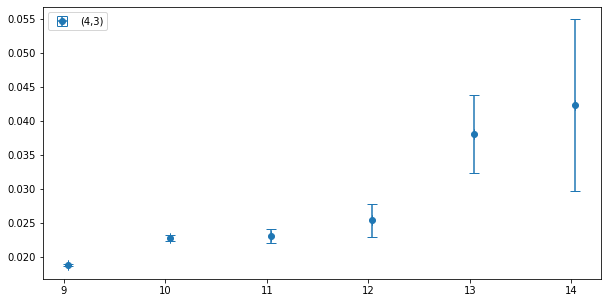

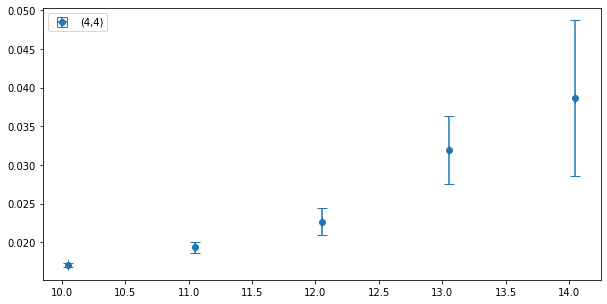

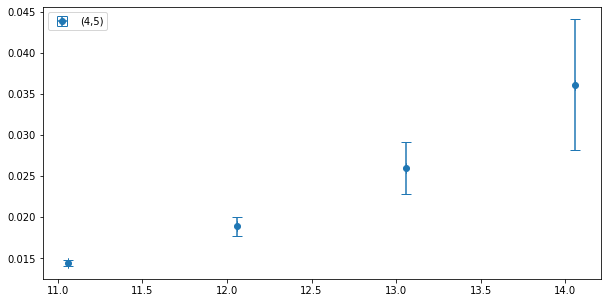

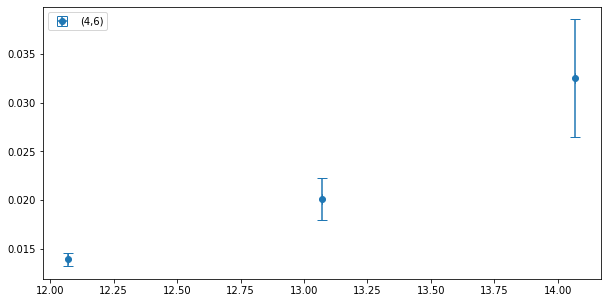

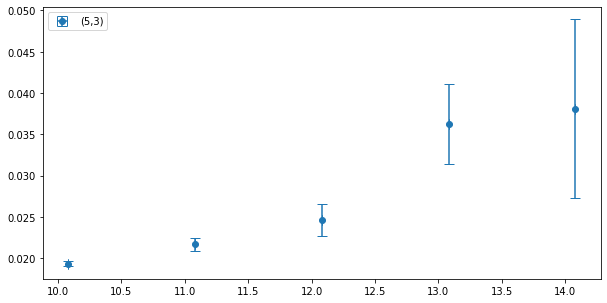

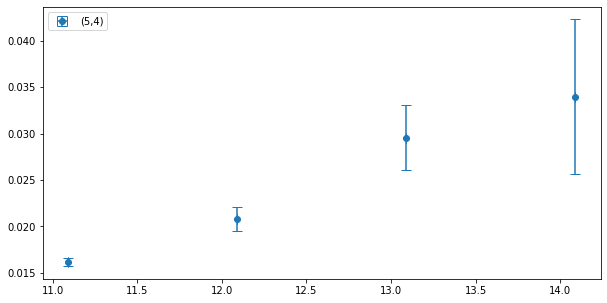

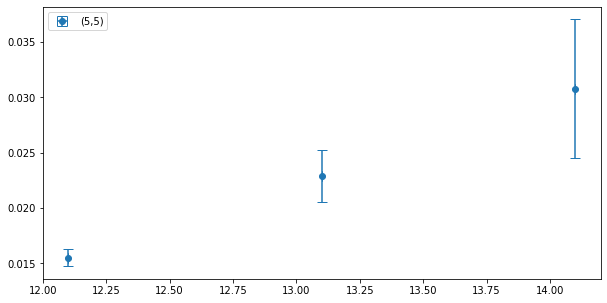

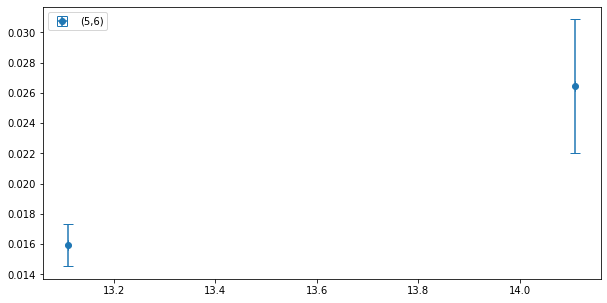

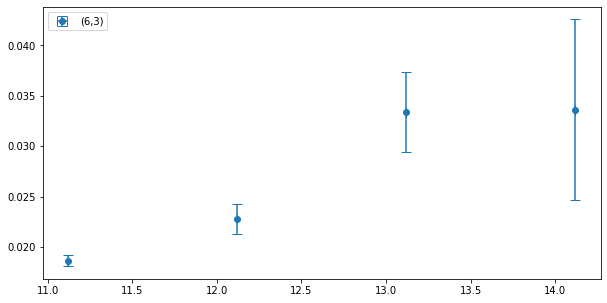

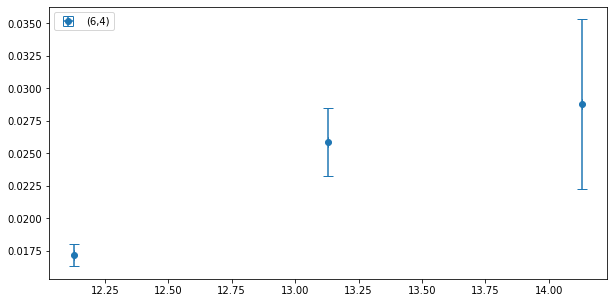

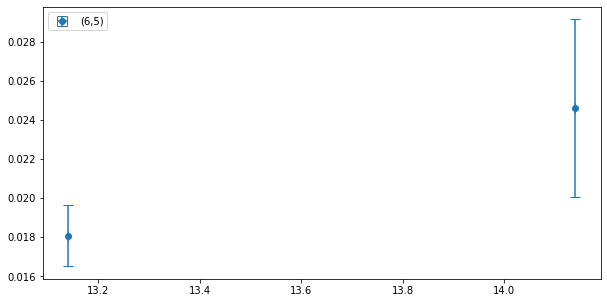

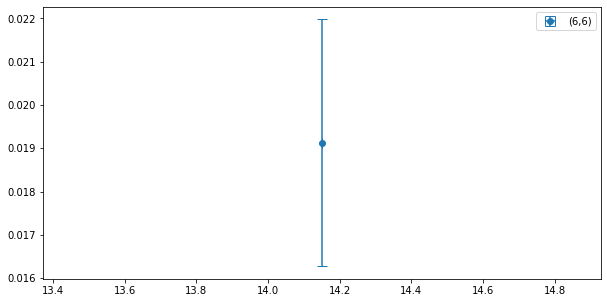

In [76]:


count = 0
for dsrc, dsnk in itertools.product([3,4,5,6], repeat=2):
    fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
    x = sumdata['tsnk'].values
    y = sumdata[f'{dsrc}:{dsnk}'].values
    y = (y[2:] - y[:-2])/2
    plt.errorbar(ax, np.arange(len(y))+min(x)+count*0.01, y, fmt='o', capsize=5, label=f'({dsrc},{dsnk})')

    count += 1
#     ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.legend()

### Individual fits

In [77]:
def summation_model_single(x, p):
    xx = x['tsnk'] - x['dsrc'] - x['dsnk']
    return p['A'] + p['B']*xx + p['C']*np.exp(-p['dE']*xx)

def summation_model_line(x, p):
    xx = x['tsnk'] - x['dsrc'] - x['dsnk']
    return p['A'] + p['B']*xx

def poly(x, p):
    return sum(pn*x**n for n, pn in enumerate(p))

def add_errs(arr, frac=0.1):
    tmp = []
    for elt in arr:
        if elt == 0:
            tmp.append(gv.gvar(0, 1))
        else:
            tmp.append(gv.gvar(elt, elt*frac))
    return np.array(tmp)


sumresults = []    
# for dsrc in [3,4]:#5,6]:
#     dsnk = dsrc
for dsrc, dsnk in itertools.product([3, 4], repeat=2):
    df = sumdata[~sumdata[f'{dsrc}:{dsnk}'].isna()]
    for tmin in [0,1,2,3,]:#4,5,6]:
        for tmax in [None, -1, -2]:
            x = {'tsnk': df['tsnk'].values[tmin:tmax], 'dsrc': dsrc, 'dsnk': dsnk}
            y = df[f'{dsrc}:{dsnk}'].values[tmin:tmax]
            if len(y) > 4:

                ##############           
                # Full model #
                ##############
                prior = {
                    'A': gv.gvar(-0.15, 10.55),
                    'B': gv.gvar(0.025, 10.055),
                    'C': gv.gvar(1e-3, 1.0),
                    'log(dE)': np.log(gv.gvar(1.0, 0.75)),
                }
                fit = lsqfit.nonlinear_fit(data=(x, y), fcn=summation_model_single, prior=prior)
                weight = aic_model_probability(fit)
                ndata = len(y)
                nparams = 4
                p_value = stats.correlated_p(fit.chi2, ndata, nparams)
                sumresults.append({
                    'fit': fit,
                    'chi2/dof': fit.chi2/fit.dof,
                    'Q': fit.Q,
                    'A': fit.p['A'],
                    'B': fit.p['B'],
                    'C': fit.p['C'],
                    'dE': fit.p['dE'],
                    'tmin': tmin,
                    'delta': dsrc,
                    'weight': weight,
                    'model': 'full',
                    'ndata': ndata,
                    'nparams': nparams,
                    'p_value': p_value,
                })

            if len(y) > 2:
                #############
                # Line only #
                #############
                prior = {
                    'A': gv.gvar(-0.15, 10.55),#-0.55),
                    'B': gv.gvar(0.025, 10.055),#0.055),
                }
                fit = lsqfit.nonlinear_fit(data=(x, y), fcn=summation_model_line, prior=prior)
                ndata = len(y)
                nparams = 2
                p_value = stats.correlated_p(fit.chi2, ndata, nparams)
                                
                weight = aic_model_probability(fit)
                sumresults.append({
                    'fit': fit,
                    'chi2/dof': fit.chi2/fit.dof,
                    'Q': fit.Q,
                    'A': fit.p['A'],
                    'B': fit.p['B'],
                    'C': np.nan,
                    'dE': np.nan,
                    'tmin': tmin,
                    'tmax': tmax,
                    'dsrc': dsrc,
                    'dsnk': dsnk,
                    'weight': weight,
                    'model': 'line',
                    'ndata': ndata,
                    'nparams': nparams,
                    'p_value': p_value,
                })

        
sumresults = pd.DataFrame(sumresults)
sumresults['weight'] = sumresults['weight']/sumresults['weight'].sum()


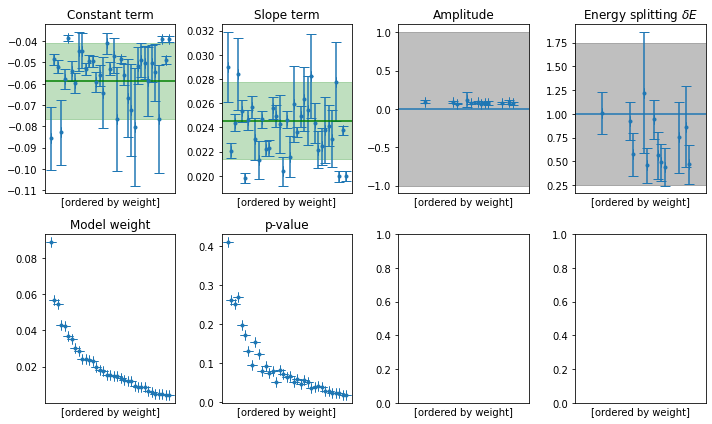

In [78]:
fig, axarr = plt.subplots(ncols=4, nrows=2, figsize=(10, 6), sharex=True)

mask =\
    (sumresults['chi2/dof'] <= 2) &\
    (sumresults['B'].apply(analysis.n2s) < 1.0) &\
    ~((sumresults['tmin'] > 0) & (sumresults['model'] == 'full'))

df = sumresults[mask].sort_values(by=['weight'], ascending=False)

y = df['A'].values
x = np.arange(len(y))
plt.errorbar(axarr[0,0], x, y, fmt='.', capsize=5)
# plt.errorbar(axarr[1,0], x, analysis.n2s(y), fmt='.', capsize=5)
plt.errorbar(axarr[1,0], x, df['weight'].values, fmt='.', capsize=5)
plt.errorbar(axarr[1,1], x, df['p_value'].values, fmt='.', capsize=5)
# plt.axhline(axarr[0], y=prior['A'], color='k')
plt.axhline(axarr[0,0], stats.model_avg(y, df['weight'].values), color='g')

y = df['B'].values
x = np.arange(len(y))
plt.errorbar(axarr[0,1], x, y, fmt='.', capsize=5)
# plt.errorbar(axarr[1,1], x, analysis.n2s(y), fmt='.', capsize=5)
# plt.axhline(axarr[1], y=prior['B'], color='k')
plt.axhline(axarr[0,1], stats.model_avg(y, df['weight'].values), color='g')
# plt.axhline(axarr[1,1], analysis.n2s(stats.model_avg(y, df['weight'].values)), color='g')

y = df['C'].values
x = np.arange(len(y))
plt.errorbar(axarr[0,2], x, y, fmt='.', capsize=5)
# plt.errorbar(axarr[1,2], x, analysis.n2s(y), fmt='.', capsize=5)
plt.axhline(axarr[0,2], y=gv.gvar(1e-3, 1.0))
plt.axhline(axarr[0,2], stats.model_avg(y, df['weight'].values), color='g')

y = df['dE'].values
x = np.arange(len(y))
plt.errorbar(axarr[0,3], x, y, fmt='.', capsize=5)
# plt.errorbar(axarr[1,3], x, analysis.n2s(y), fmt='.', capsize=5)
plt.axhline(axarr[0,3], y=gv.gvar(1.0, 0.75))
plt.axhline(axarr[0,3], stats.model_avg(y, df['weight'].values), color='g')

axarr[0,0].set_title("Constant term")
axarr[0,1].set_title("Slope term")
axarr[0,2].set_title("Amplitude")
axarr[0,3].set_title(r"Energy splitting $\delta E$")


axarr[1,0].set_title("Model weight")
axarr[1,1].set_title("p-value")

for ax in np.ravel(axarr):
    ax.set_xticks([])
    ax.set_xlabel("[ordered by weight]")

fig.tight_layout()

In [79]:
df[['chi2/dof','A','B','tmin','tmax','dsrc','dsnk','model','p_value','weight','ndata','nparams']]

,chi2/dof,A,B,tmin,tmax,dsrc,dsnk,model,p_value,weight,ndata,nparams
80,0.444602,-0.086(15),0.0290(29),3,NaN,4.0,4.0,line,0.410983,0.088909,4,2
39,0.670241,-0.0486(27),0.02207(64),2,-2.0,3.0,4.0,line,0.261719,0.056618,4,2
60,0.690232,-0.0520(30),0.02440(72),2,-2.0,4.0,3.0,line,0.251462,0.054399,4,2
81,0.408014,-0.083(15),0.0284(30),3,-1.0,4.0,4.0,line,0.268569,0.043155,3,2
22,0.813556,-0.0577(48),0.02534(92),3,-2.0,3.0,3.0,line,0.196496,0.042508,4,2
75,0.885142,-0.0385(14),0.01981(44),1,-2.0,4.0,4.0,line,0.170285,0.036838,4,2
4,0.803218,-0.0541(46),0.02462(83),0,NaN,NaN,NaN,full,0.131491,0.035359,7,4
19,1.323468,-0.0596(47),0.02570(91),3,NaN,3.0,3.0,line,0.093771,0.030157,6,2
64,0.682074,-0.0448(90),0.0231(17),3,-2.0,4.0,3.0,line,0.152584,0.028608,3,2
43,0.797263,-0.0444(81),0.0213(16),3,-2.0,3.0,4.0,line,0.121974,0.024069,3,2


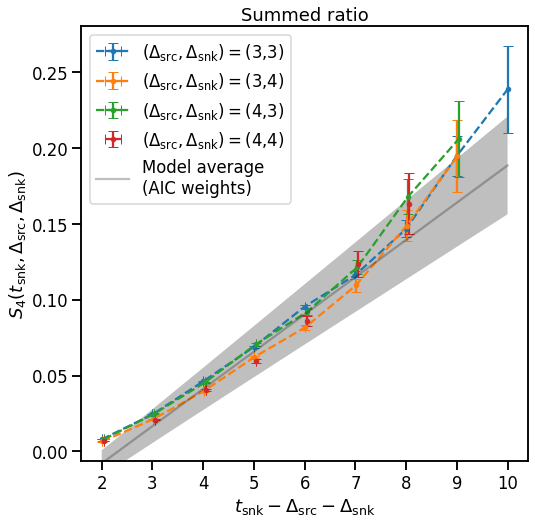

In [80]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(ncols=1, figsize=(8, 8))

    for idx, (dsrc, dsnk) in enumerate(itertools.product([3,4,5,6], repeat=2)):
        if (dsrc, dsnk) not in [(3,3), (3,4), (4,3), (4,4)]:
            continue
        offset = idx*0.01
        x = sumdata['tsnk'].values - dsrc - dsnk + offset
        y = sumdata[f'{dsrc}:{dsnk}'].values
        if (dsrc, dsnk) in [(3,3),(3,4),(4,3)]:
            fmt = '.--'
        else:
            fmt = '.'
        plt.errorbar(ax, x, y, fmt=fmt, capsize=5,
                     label=r"$(\Delta_{\rm src}, \Delta_{\rm snk})=$"+f"({dsrc},{dsnk})")


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    mask =\
        (sumresults['chi2/dof'] <= 2) &\
        (sumresults['B'].apply(analysis.n2s) < 1.0) &\
        ~((sumresults['tmin'] > 0) & (sumresults['model'] == 'full'))

    df = sumresults[mask].sort_values(by=['weight'], ascending=False)
    slope = stats.model_avg(df['B'].values, df['weight'].values)

    mask = mask & (sumresults['dsrc'] == 3) & (sumresults['dsnk'] == 3)
    df = sumresults[mask]
    intercept = stats.model_avg(df['A'].values, df['weight'].values)

    x = np.linspace(2, 10)
    y = intercept + slope*x
    plt.errorbar(ax, x, y, color='k', bands=True, alpha=0.25,
                 label='Model average\n(AIC weights)')



    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.legend()
    ax.set_xlabel(r"$t_{\rm snk} - \Delta_{\rm src} - \Delta_{\rm snk}$")
    ax.set_ylabel(r"$S_4(t_{\rm snk}, \Delta_{\rm src}, \Delta_{\rm snk})$")
    ax.set_title("Summed ratio")

In [81]:
mask =\
    (sumresults['chi2/dof'] <= 2) &\
    (sumresults['B'].apply(analysis.n2s) < 1.0) &\
    ~((sumresults['tmin'] > 0) & (sumresults['model'] == 'full')) &\
    (sumresults['model'] == 'line') &\
    (sumresults['dsrc'] == 3) &\
    (sumresults['dsnk'] == 3)

df = sumresults[mask].sort_values(by=['weight'], ascending=False)
fit = df.head(1)['fit'].item()
print(fit.format(maxline=True))

Least Square Fit:
  chi2/dof [dof] = 0.81 [4]    Q = 0.52    logGBF = 0.86422

Parameters:
              A   -0.0577 (48)      [  -0.1 (10.6) ]  
              B   0.02534 (92)      [ 0.03 (10.05) ]  

Fit:
      key          y[key]       f(p)[key]
-----------------------------------------
        0    0.06890 (56)    0.06899 (55)  
        1     0.0955 (12)    0.09433 (91)  
        2     0.1163 (26)     0.1197 (17)  *
        3     0.1466 (56)     0.1450 (26)  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 3/0.0)
  fitter = scipy_least_squares    method = trf



#### other stuff

In [82]:
def summation_model_base(dsrc, dsnk, tsnk, p):
    x = tsnk - dsrc - dsnk
    p0 = p[f'p0:{dsrc}:{dsnk}']
    amp = p[f'amp:{dsrc}:{dsnk}']
#     amp = p['amp']
    p1 = p['p1']
    dE = p['dE']
    exp_terms = np.sum([ai*np.exp(-Ei*x) for ai, Ei in zip(amp, np.cumsum(dE))], axis=0)
    
    return p0 + p1*x + exp_terms
    #p['p2']*x**2 + p['p3']*x**3
    
def summation_model(x, p):
    y = {}
    for key in x:
        tsnk = x[key]
        dsrc, dsnk = key    
        y[key] = summation_model_base(dsrc, dsnk, tsnk, p)
    return y
            

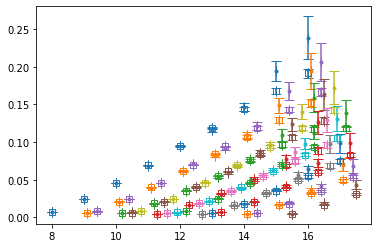

In [83]:
x = {key: sumdata2[key].values for key in ['tsnk', 'dsrc', 'dsnk']}
y = sumdata2['ratio'].values

groups = sumdata2.groupby(['dsrc','dsnk'])
x = {key: df['tsnk'].values for key, df in groups}
y = {key: df['ratio'].values for key, df in groups}

p = {
    'p1': 0.025,
#     'p2': 0,
#     'p3': 0,
    'dE': [0.5, 0.5],
#     'amp': [1e-3, 1e-3],
}
for dsrc, dsnk in groups.groups.keys():
    p[f'p0:{dsrc}:{dsnk}'] = -0.05
    p[f'amp:{dsrc}:{dsnk}'] = [1e-3, 1e-3]



fit = lsqfit.nonlinear_fit(data=(x, y), fcn=summation_model, p0=p)
yfit = fit.fcn(x, fit.p)



fig, ax = plt.subplots(1)
for idx, key in enumerate(x):
    offset = idx*0.1
    plt.errorbar(ax, x[key]+offset, y[key], fmt='.', capsize=5)
    plt.errorbar(ax, x[key]+offset, yfit[key], fmt='s', capsize=5,
                 markerfacecolor='none', color=ax.lines[-1].get_color())


# # x = (sumdata2['tsnk'] - sumdata2['dsrc'] - sumdata2['dsnk']).values
# x = sumdata2['tsnk']
# plt.errorbar(ax, x+0.1, yfit, fmt='.', label='model')

# y = sumdata2['ratio']
# plt.errorbar(ax, x, y, fmt='.', label='data')

# ax.legend()




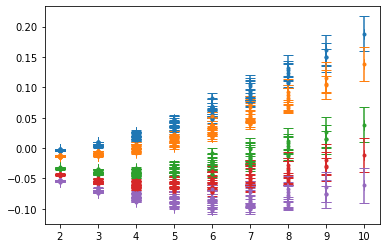

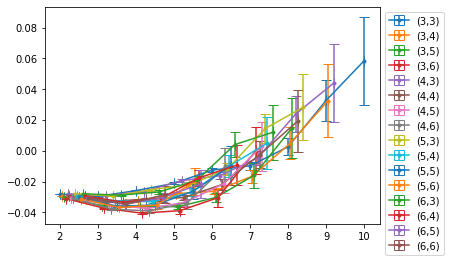

In [84]:
fig, ax = plt.subplots(1)
y = sumdata2['ratio'].values
x = (sumdata2['tsnk'] - sumdata2['dsrc'] - sumdata2['dsnk']).values

for guess in [0.005, 0.01, 0.02, 0.025, 0.03]:
    plt.errorbar(ax, x, y - guess*x, fmt='.', capsize=5)
    
fig, ax = plt.subplots(1)
for idx, ((dsrc, dsnk), df) in enumerate(sumdata2.groupby(['dsrc','dsnk'])):

    y = df['ratio'].values
    x = (df['tsnk'] - df['dsrc'] - df['dsnk']).values

    guess = 0.018
    plt.errorbar(ax, x+0.05*idx, y - guess*x, fmt='.-', capsize=5, label=f"({dsrc},{dsnk})")    
ax.legend(bbox_to_anchor=(1.0, 1.0))

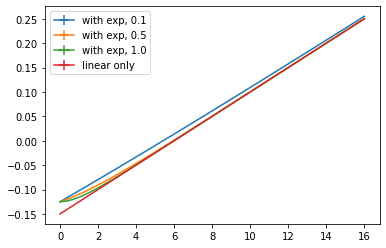

In [85]:
fig, ax = plt.subplots(1)

x = np.linspace(0, 16)
y = -0.15 + 0.025*(x + np.exp(-x*0.1))
plt.errorbar(ax, x, y, label='with exp, 0.1')

y = -0.15 + 0.025*(x + np.exp(-x*0.5))
plt.errorbar(ax, x, y, label='with exp, 0.5')

y = -0.15 + 0.025*(x + np.exp(-x*1.0))
plt.errorbar(ax, x, y, label='with exp, 1.0')

y = -0.15 + 0.025*(x + 0)
plt.errorbar(ax, x, y, label='linear only')

ax.legend()

### Comparing all results

In [ ]:
mask =\
    (sumresults['chi2/dof'] <= 2) &\
    (sumresults['B'].apply(analysis.n2s) < 1.0) &\
    ~((sumresults['tmin'] > 0) & (sumresults['model'] == 'full'))

df = sumresults[mask].sort_values(by=['weight'], ascending=False)

with sns.plotting_context('paper'):

    fig, axarr = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)
    
    y = df['B'].values
    x = np.linspace(-3, -1, num=len(y))
    mask = df['model'] == 'full'    
    plt.errorbar(axarr[0], x=x[mask], y=y[mask], fmt='o', capsize=5,
                 label="Summation Method\n(linear)")    
    plt.errorbar(axarr[0], x=x[~mask], y=y[~mask], fmt='o', capsize=5,
                 label="Summation Method\n(linear + exponential)",
                 color=axarr[0].lines[-1].get_color(), markerfacecolor='none')
#     plt.errorbar(axarr[1], x=x, y=analysis.n2s(y), fmt='o', capsize=5, label="Summation Method")
    plt.errorbar(ax=axarr[0], x=[-3, -0.5], y=np.ones(2)*stats.model_avg(df['B'].values, df['weight'].values),
                 bands=True, color=axarr[0].lines[-1].get_color(), alpha=0.25,
                 label='Summation-method average\n(AIC weight)'
                )
    plt.errorbar(axarr[1], x=x, y=df['weight'].values, fmt='o')
    
    
    
    y = 2*a0avg/E0avg
    x = 0
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Global-fit average\n(AIC weights)")
#     plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Global-fit average\n(AIC weights)")

    y = 2*a0pick/E0pick
    x = 1
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Global-fit average\n(uniform weights)")
#     plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Global-fit average\n(uniform weights)")

    p = fit_alternative.p
    y = 2*p['a0']/p['E0']
    x = 2
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Sequential fitting\nstrategy")
#     plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Sequential\nfitting strategy")    

    y = 2*gv.gvar(0.011, 0.1*0.011)
    x = 3
    plt.errorbar(axarr[0], x, y, fmt='o', capsize=5, label="Anthony's fit\n(rough estimate)")
#     plt.errorbar(axarr[1], x, analysis.n2s(y), fmt='o', capsize=5, label="Anthony")    

    axarr[0].axvline(x=-0.5, color='grey', ls='--')
#     axarr[1].axvline(x=-0.5, color='grey', ls='--')    
    
    
#     for ax in axarr:    
#         ax.set_xticks(range(-4, 4))
#         ax.set_xticklabels(
#             [r"$n=$"+str(n) for n in range(2,6)]+\
#             ["" for _ in range(4)])
    
    axarr[0].set_ylabel(r"$2A/E$")
#     axarr[1].set_ylabel(r"Fractional error $2A/E$")
    axarr[1].set_ylabel(r"Model weight (AIC)")
#     axarr[1].set_ylim(bottom=0)
    axarr[0].legend(bbox_to_anchor=(1,1))
    fig.tight_layout()
#     fig.savefig(f"Figures/results_comparison_{today}.pdf")


In [ ]:
# TODO save this and add to a backup slide